## Imports

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import numpy as np
from datetime import datetime
import pytz
import json
import math
import warnings

# just for matplotlib, due to non recognized character
warnings.filterwarnings("ignore", module = "matplotlib\..*" )

# config for non latin words.
# There is a Korean word: 위키백과탈퇴, which is the Korean template for Retired
# https://www.wikidata.org/wiki/Q5848674
matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'DejaVu Sans']

## Getting the data ready to be analyzed

In [182]:
italian_wikibreaks_df = pd.read_json('../../wikidump/wikibreaks_refactored/itwiki_20210201_wikibreaks_without_band_refactored.json.gz', compression='gzip', lines=True)
# italian_wikibreaks_df.head()

In [183]:
active_users_amount_file = open('../../wikidump/wikibreaks_refactored/itwiki_active_users.json')
active_users_amount = json.load(active_users_amount_file)
active_users_amount_file.close()

Number of rows and columns

In [184]:
italian_wikibreaks_df.shape

(1386, 5)

Basic info about the Pandas dataframe

In [185]:
italian_wikibreaks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikibreaks    1386 non-null   object 
 1   id_talk_page  754 non-null    float64
 2   name          1386 non-null   object 
 3   id_user_page  894 non-null    float64
 4   ambiguous     1386 non-null   bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 44.8+ KB


Basic stats

In [186]:
italian_wikibreaks_df.describe()

,id_talk_page,id_user_page
count,7.540000e+02,8.940000e+02
mean,3.501854e+06,3.183925e+06
std,2.335435e+06,2.341276e+06
min,1.447500e+04,8.786000e+03
25%,1.604497e+06,1.227672e+06
50%,3.042408e+06,2.797916e+06
75%,5.067654e+06,4.625846e+06
max,8.770471e+06,8.814765e+06


#### Plot the graph chart to see ambiguous information retrieved

In [187]:
ambiguous_count = italian_wikibreaks_df
ambiguous_count['count'] = 1
ambiguous_count = ambiguous_count[['ambiguous', 'count']].groupby('ambiguous').count().reset_index()
ambiguous_count

,ambiguous,count
0,False,1314
1,True,72


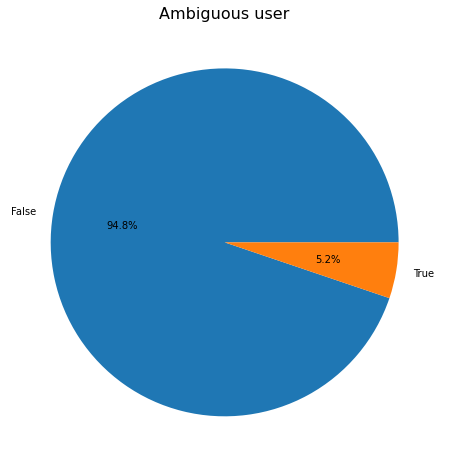

In [188]:
plt.figure(figsize=(16,8))
plt.pie(ambiguous_count['count'], labels=ambiguous_count['ambiguous'], autopct='%.1f%%')
plt.title('Ambiguous user', fontsize=16)
plt.show()

### Explicit the Wikibreaks

In [189]:
italian_wikibreaks_refactored_df = list()
# iterating over the previous dataset
for i, row in italian_wikibreaks_df.iterrows():
    # explicit the wikibreaks
    for el in row['wikibreaks']:
        new_row = row
        new_row = new_row.drop('wikibreaks')
        new_row['wikibreak'] = el['name']
        new_row['categories'] = el['categories']
        new_row['parameters'] = el['parameters']
        new_row['subcategory'] = el['subcategory']
        if el['to_date']:
            new_row['to_date'] = datetime.fromisoformat(el['to_date'])
        else:
            new_row['to_date'] = None
        new_row['from_date'] = datetime.fromisoformat(el['from_date'])
        italian_wikibreaks_refactored_df.append(new_row)
italian_wikibreaks_refactored_df = pd.DataFrame(italian_wikibreaks_refactored_df).reset_index(drop=True)
# italian_wikibreaks_refactored_df.head()

In [190]:
italian_wikibreaks_refactored_df.shape

(3583, 11)

## Number of users still in wikibreaks or similar

In [191]:
still_in_breaks = italian_wikibreaks_refactored_df.loc[pd.isnull(italian_wikibreaks_refactored_df['to_date']), ['name', 'wikibreak', 'categories', 'subcategory']]
# still_in_breaks.head()

In [192]:
# still_in_breaks.describe()

In [193]:
users_still_in_breaks = still_in_breaks.groupby('name').count().reset_index()
# users_still_in_breaks.head()

In [194]:
users_still_in_breaks.describe()

,wikibreak,categories,subcategory
count,353.000000,353.000000,353.000000
mean,1.201133,1.201133,1.201133
std,0.609395,0.609395,0.609395
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000


## Number of users still in wikibreaks with respect to the total amount of users who specified at least a wikibreak during their wikihistory

In [195]:
italian_wikibreaks_df.shape[0]

1386

In [196]:
users_still_in_breaks.shape[0]

353

In [197]:
row_total = {'total': italian_wikibreaks_df.shape[0] - users_still_in_breaks.shape[0], 'label': 'not in break'}
row_break = {'total': users_still_in_breaks.shape[0], 'label': 'in break'}
rows = [row_total, row_break]
percentage_still_in_break = pd.DataFrame(rows).reset_index(drop=True)
percentage_still_in_break

,total,label
0,1033,not in break
1,353,in break


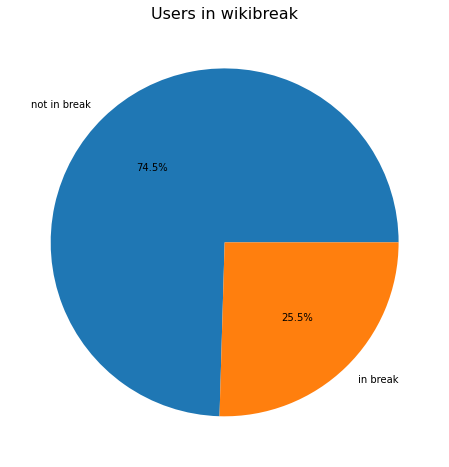

In [198]:
plt.figure(figsize=(16,8))
plt.pie(percentage_still_in_break['total'], labels=percentage_still_in_break['label'], autopct='%.1f%%')
plt.title('Users in wikibreak', fontsize=16)
plt.show()

## Users who have used wikibreaks over the total amount of users who have been active

In [199]:
active_users_amount['tot']

189772

In [200]:
row_total = {'total': active_users_amount['tot'] - italian_wikibreaks_df.shape[0], 'label': 'users who have been active'}
row_break = {'total': italian_wikibreaks_df.shape[0], 'label': 'users who went in break'}
rows = [row_total, row_break]
percentage_compared_with_activity = pd.DataFrame(rows).reset_index(drop=True)
percentage_compared_with_activity

,total,label
0,188386,users who have been active
1,1386,users who went in break


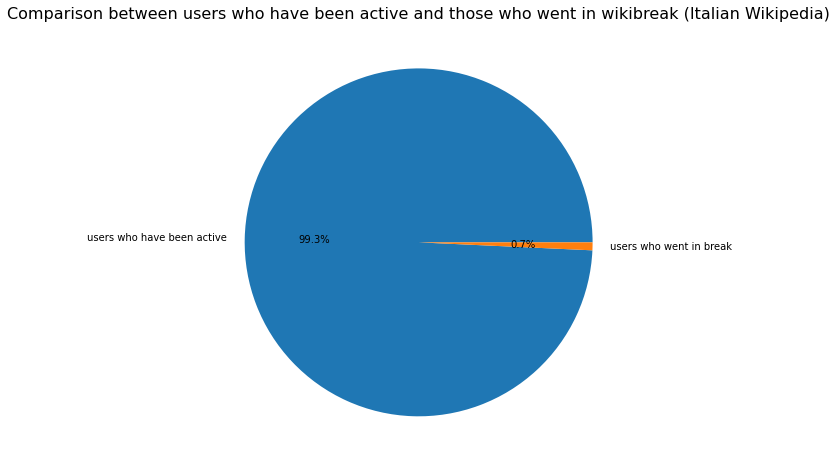

In [201]:
plt.figure(figsize=(16,8))
plt.pie(percentage_compared_with_activity['total'], labels=percentage_compared_with_activity['label'], autopct='%.1f%%')
plt.title('Comparison between users who have been active and those who went in wikibreak (Italian Wikipedia)', fontsize=16)
plt.show()

## Users still in break over the total amount of users who have been active

In [202]:
active_users_amount['tot']

189772

In [203]:
row_total = {'total': active_users_amount['tot'] - users_still_in_breaks.shape[0], 'label': 'users who have been active'}
row_break = {'total': users_still_in_breaks.shape[0], 'label': 'users currently in break'}
rows = [row_total, row_break]
percentage_compared_with_activity_still_in_break = pd.DataFrame(rows).reset_index(drop=True)
percentage_compared_with_activity_still_in_break

,total,label
0,189419,users who have been active
1,353,users currently in break


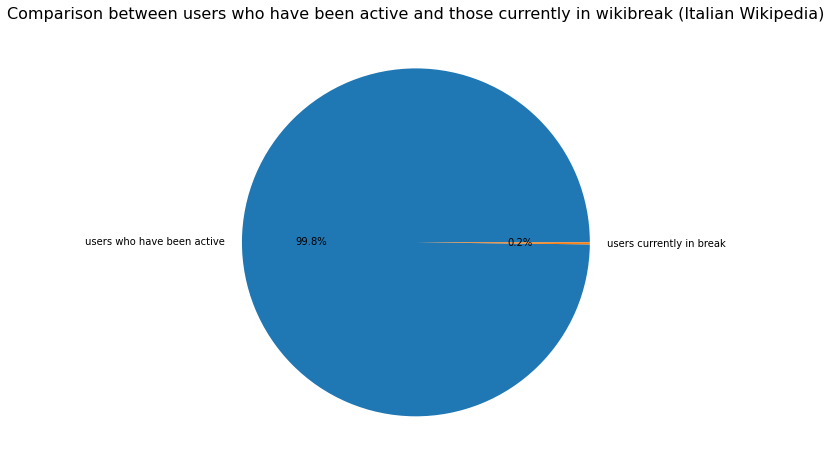

In [204]:
plt.figure(figsize=(16,8))
plt.pie(percentage_compared_with_activity_still_in_break['total'], labels=percentage_compared_with_activity_still_in_break['label'], autopct='%.1f%%')
plt.title('Comparison between users who have been active and those currently in wikibreak (Italian Wikipedia)', fontsize=16)
plt.show()

## Current wikibreaks templates

In [205]:
wikibreaks_still_in_breaks = still_in_breaks
wikibreaks_still_in_breaks['count'] = 1
wikibreaks_still_in_breaks = wikibreaks_still_in_breaks[['wikibreak', 'count']].groupby('wikibreak').count().reset_index()
wikibreaks_still_in_breaks.head()

,wikibreak,count
0,busy,1
1,esami,16
2,exams,1
3,malattia scherzo,10
4,occupato,135


In [206]:
wikibreaks_still_in_breaks.shape

(16, 2)

In [207]:
wikibreaks_still_in_breaks.describe()

,count
count,16.000000
mean,26.500000
std,34.571665
min,1.000000
25%,3.750000
50%,17.000000
75%,31.250000
max,135.000000


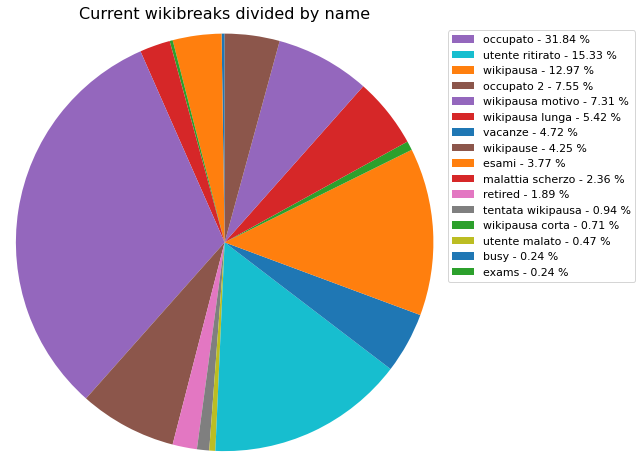

In [208]:
plt.figure(figsize=(16, 8))
plt.title('Current wikibreaks divided by name', fontsize=16)

wikibreaks = wikibreaks_still_in_breaks['wikibreak']
values = wikibreaks_still_in_breaks['count']
percentage = 100.*values/values.sum()

patches, texts = plt.pie(values, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(wikibreaks, percentage)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, values), key=lambda x: x[2], reverse=True))

plt.legend(patches, labels, bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## Current subcategories

In [209]:
subcategories_still_in_breaks = still_in_breaks
subcategories_still_in_breaks['count'] = 1
subcategories_still_in_breaks = subcategories_still_in_breaks[['subcategory', 'count']].groupby('subcategory').count().reset_index().sort_values(['count'], ascending=False)
subcategories_still_in_breaks.head()

,subcategory,count
0,busy,168
6,wikibreak,134
2,retired,73
5,vacation,20
1,exams,17


In [210]:
subcategories_still_in_breaks.shape

(7, 2)

In [211]:
subcategories_still_in_breaks.describe()

,count
count,7.000000
mean,60.571429
std,66.607950
min,2.000000
25%,13.500000
50%,20.000000
75%,103.500000
max,168.000000


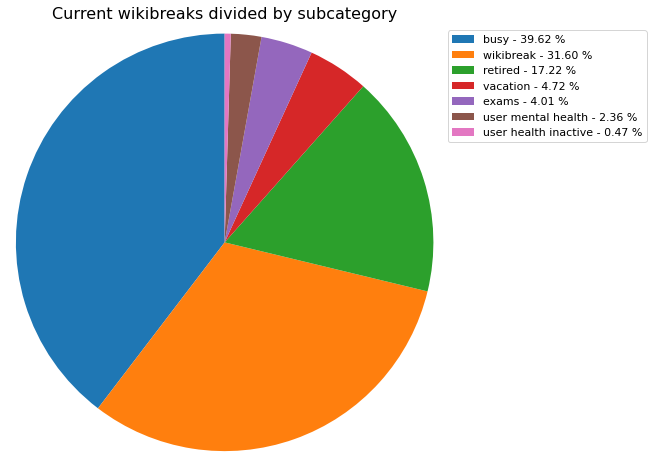

In [212]:
plt.figure(figsize=(16, 8))
plt.title('Current wikibreaks divided by subcategory', fontsize=16)

wikibreaks = subcategories_still_in_breaks['subcategory']
values = subcategories_still_in_breaks['count']
percentage = 100.*values/values.sum()

patches, texts = plt.pie(values, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(wikibreaks, percentage)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, values), key=lambda x: x[2], reverse=True))

plt.legend(patches, labels, bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## Current categories

In [213]:
categories_still_in_breaks = still_in_breaks[['categories', 'name']]
categories_still_in_breaks_refactored = list()
for i, row in categories_still_in_breaks.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        categories_still_in_breaks_refactored.append(new_row)
categories_still_in_breaks_refactored = pd.DataFrame(categories_still_in_breaks_refactored).reset_index(drop=True)
# categories_still_in_breaks_refactored.head()

In [214]:
categories_still_in_breaks_refactored = categories_still_in_breaks_refactored
categories_still_in_breaks_refactored['count'] = 1
categories_still_in_breaks_refactored = categories_still_in_breaks_refactored[['category', 'count']].groupby('category').count().reset_index().sort_values(['count'], ascending=False)
categories_still_in_breaks_refactored.head()

,category,count
2,mental,178
0,break,171
3,other,73
1,health related,12


In [215]:
categories_still_in_breaks_refactored.shape

(4, 2)

In [216]:
categories_still_in_breaks_refactored.describe()

,count
count,4.000000
mean,108.500000
std,80.226762
min,12.000000
25%,57.750000
50%,122.000000
75%,172.750000
max,178.000000


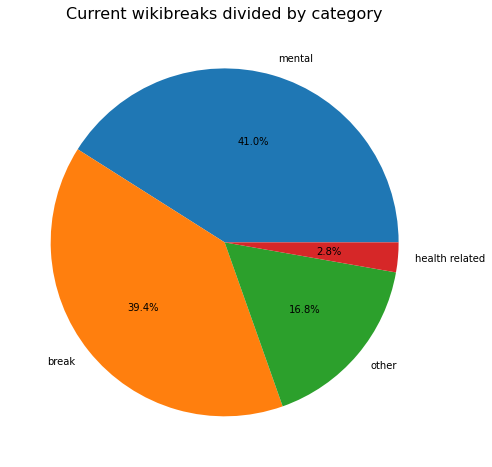

In [217]:
plt.figure(figsize=(16,8))
plt.pie(categories_still_in_breaks_refactored['count'], labels=categories_still_in_breaks_refactored['category'], autopct='%.1f%%')
plt.title('Current wikibreaks divided by category', fontsize=16)
plt.show()

# Line graph to see the flow of wikibreaks in Italian Wikipedia

In [218]:
# unique wikibreaks
# THE NON RENDERING FONT IS https://www.wikidata.org/wiki/Q5848674
wikibreaks = italian_wikibreaks_refactored_df['wikibreak'].unique()
wikibreaks

array(['esami', 'wikipausa motivo', 'wikipausa', 'vacanze',
       'utente ritirato', 'wikipause', 'occupato', 'wikipausa corta',
       'malattia scherzo', 'retired', 'wikipausa lunga', 'occupato 2',
       '위키백과탈퇴', 'tentata wikipausa', 'exams', 'utente malato',
       'wikibreak', 'busy', 'dead', 'semi-retired'], dtype=object)

In [219]:
# unique subcategories
subcategories = italian_wikibreaks_refactored_df['subcategory'].unique()
subcategories

array(['exams', 'wikibreak', 'vacation', 'retired', 'busy',
       'user mental health', 'user health inactive',
       'deceased wikipedian', 'semi-retired'], dtype=object)

In [220]:
# unique categories
categories = list()
for i, row in italian_wikibreaks_refactored_df[['categories', 'name']].iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        categories.append(new_row)
categories = pd.DataFrame(categories).reset_index(drop=True)
categories = categories['category'].unique()
categories

array(['break', 'other', 'mental', 'health related'], dtype=object)

In [221]:
# date to start from
start_from = italian_wikibreaks_refactored_df['from_date'].min()
start_from

Timestamp('2006-05-26 19:49:28+0000', tz='UTC')

In [222]:
last_date = datetime.now().replace(tzinfo=pytz.UTC)
last_date

datetime.datetime(2021, 5, 6, 14, 40, 16, 711801, tzinfo=<UTC>)

In [223]:
breaks_history = list()
breaks_history_per_month = list()

italian_wikibreaks_simple_date = italian_wikibreaks_refactored_df
italian_wikibreaks_simple_date['from_date'] = italian_wikibreaks_simple_date['from_date'].dt.normalize()
italian_wikibreaks_simple_date['from_date'] = italian_wikibreaks_simple_date['from_date'].apply(lambda r: r.replace(day=1))
italian_wikibreaks_simple_date['to_date'] = italian_wikibreaks_simple_date['to_date'].dt.normalize()
italian_wikibreaks_simple_date['to_date'] = italian_wikibreaks_simple_date['to_date'].apply(lambda r: r.replace(day=1))
# iterating over years
for year in range(start_from.year, last_date.year + 1):
    if year == start_from.year: # first year
        start_month = start_from.month
    else:
        start_month = 1
    
    if year == last_date.year: # last year
        last_month = last_date.month
    else:
        last_month = 12
    
    for month in range(start_month, last_month + 1):
        # specified in the given month
        mask = year == italian_wikibreaks_simple_date['from_date'].dt.year
        mask2 = italian_wikibreaks_simple_date['from_date'].dt.month == month
        mask = mask & mask2
        this_month_df = italian_wikibreaks_simple_date[mask]
        for j, elem in this_month_df.iterrows():
            el = dict()
            el['year'] = year
            el['month'] = month
            el['subcategory'] = elem['subcategory']
            el['wikibreak'] = elem['wikibreak']
            el['categories'] = elem['categories']
            breaks_history_per_month.append(el)
        
        # active at that time
        mask = (italian_wikibreaks_simple_date['from_date'] <= datetime(year, month, 1).replace(tzinfo=pytz.UTC))
        mask_2 = (pd.isnull(italian_wikibreaks_simple_date['to_date'])) | (italian_wikibreaks_simple_date['to_date'] >= datetime(year, month, 1).replace(tzinfo=pytz.UTC)) 
        mask = mask & mask_2
        filtered = italian_wikibreaks_simple_date[mask]
        for j, elem in filtered.iterrows():
            el = dict()
            el['year'] = year
            el['month'] = month
            el['subcategory'] = elem['subcategory']
            el['wikibreak'] = elem['wikibreak']
            el['categories'] = elem['categories']
            breaks_history.append(el)
breaks_history = pd.DataFrame(breaks_history).reset_index(drop=True)
breaks_history_per_month = pd.DataFrame(breaks_history_per_month).reset_index(drop=True)

In [224]:
breaks_history.head()

,year,month,subcategory,wikibreak,categories
0,2006,5,user mental health,malattia scherzo,"[health related, mental]"
1,2006,6,wikibreak,wikipause,[break]
2,2006,6,wikibreak,wikipause,[break]
3,2006,6,wikibreak,wikipause,[break]
4,2006,6,exams,esami,[break]


In [225]:
breaks_history.shape

(45889, 5)

In [226]:
breaks_history.describe()

,year,month
count,45889.000000,45889.000000
mean,2015.392883,6.482381
std,3.781659,3.430490
min,2006.000000,1.000000
25%,2013.000000,4.000000
50%,2016.000000,7.000000
75%,2019.000000,9.000000
max,2021.000000,12.000000


In [227]:
breaks_history_subcategory_count = breaks_history
breaks_history_subcategory_count['count'] = 1
breaks_history_subcategory_count = breaks_history_subcategory_count[['year', 'month', 'subcategory', 'count']].groupby(['year', 'month',  'subcategory']).count().reset_index().sort_values(['year', 'month'], ascending=True)
breaks_history_subcategory_count['date'] = pd.to_datetime(breaks_history_subcategory_count[['year','month']].assign(day=1)).dt.date
breaks_history_subcategory_count.head()

,year,month,subcategory,count,date
0,2006,5,user mental health,1,2006-05-01
1,2006,6,busy,4,2006-06-01
2,2006,6,exams,5,2006-06-01
3,2006,6,user mental health,1,2006-06-01
4,2006,6,wikibreak,6,2006-06-01


In [228]:
breaks_history_subcategory_count.tail()

,year,month,subcategory,count,date
1123,2021,5,retired,73,2021-05-01
1124,2021,5,user health inactive,2,2021-05-01
1125,2021,5,user mental health,10,2021-05-01
1126,2021,5,vacation,20,2021-05-01
1127,2021,5,wikibreak,134,2021-05-01


In [229]:
breaks_history_subcategory_count.describe()

,year,month,count
count,1128.000000,1128.000000,1128.000000
mean,2013.978723,6.477837,40.681738
std,4.230859,3.451971,46.396432
min,2006.000000,1.000000,1.000000
25%,2011.000000,3.000000,10.000000
50%,2014.000000,6.000000,19.000000
75%,2018.000000,9.000000,59.000000
max,2021.000000,12.000000,180.000000


#### Clean counter

In [230]:
breaks_history_subcategory_count_cleaned = list()
for date in breaks_history_subcategory_count['date'].unique():
    for subcat in subcategories:
        elem = breaks_history_subcategory_count.loc[(breaks_history_subcategory_count['date'] == date) & (breaks_history_subcategory_count['subcategory'] == subcat)]
        if elem.empty:
            breaks_history_subcategory_count_cleaned.append([date.year, date.month, subcat, 0, date])
        else:
            breaks_history_subcategory_count_cleaned.append(np.array(elem)[0])
breaks_history_subcategory_count_cleaned = pd.DataFrame(breaks_history_subcategory_count_cleaned).reset_index(drop=True).set_axis(['year', 'month', 'subcategory', 'count', 'date'], axis=1)
breaks_history_subcategory_count_cleaned.head()

,year,month,subcategory,count,date
0,2006,5,exams,0,2006-05-01
1,2006,5,wikibreak,0,2006-05-01
2,2006,5,vacation,0,2006-05-01
3,2006,5,retired,0,2006-05-01
4,2006,5,busy,0,2006-05-01


## Subcategories during Italian Wikipedia history

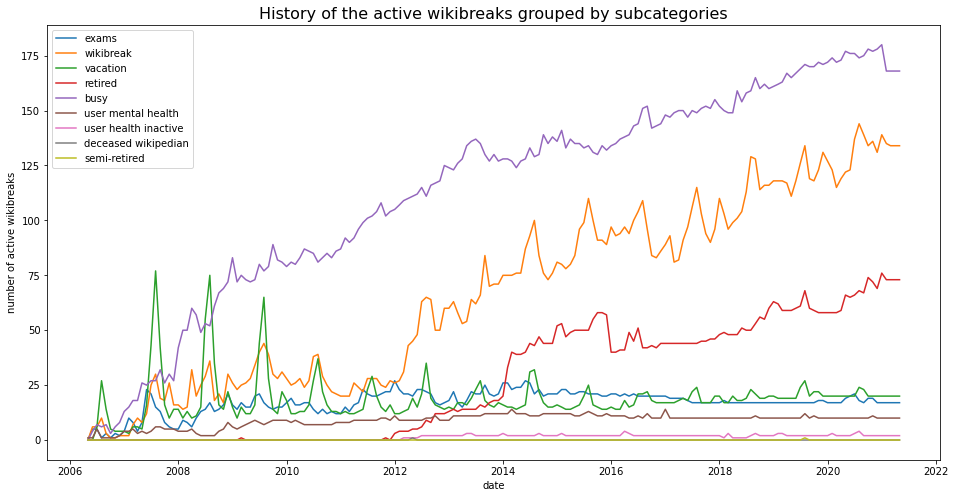

In [231]:
plt.figure(figsize=(16,8))
for subcategory in breaks_history_subcategory_count_cleaned['subcategory'].unique():
    subcat = breaks_history_subcategory_count_cleaned[breaks_history_subcategory_count_cleaned['subcategory'] == subcategory]
    plt.plot(subcat['date'], subcat['count'], label = subcategory)
plt.legend()
plt.title('History of the active wikibreaks grouped by subcategories', fontsize=16)
plt.ylabel('number of active wikibreaks')
plt.xlabel('date')
plt.show()

In [232]:
fig = px.line(breaks_history_subcategory_count_cleaned, x='date', y='count', color='subcategory', title='History of the active wikibreaks grouped by subcategories')
fig.show()

The same but with the names of the pauses

In [233]:
breaks_history_wikibreak_count = breaks_history
breaks_history_wikibreak_count['count'] = 1
breaks_history_wikibreak_count = breaks_history_wikibreak_count[['year', 'month', 'wikibreak', 'count']].groupby(['year', 'month', 'wikibreak']).count().reset_index().sort_values(['year', 'month'], ascending=True)
breaks_history_wikibreak_count['date'] = pd.to_datetime(breaks_history_wikibreak_count[['year','month']].assign(day=1)).dt.date
breaks_history_wikibreak_count.head()

,year,month,wikibreak,count,date
0,2006,5,malattia scherzo,1,2006-05-01
1,2006,6,esami,5,2006-06-01
2,2006,6,malattia scherzo,1,2006-06-01
3,2006,6,occupato,4,2006-06-01
4,2006,6,wikipause,6,2006-06-01


In [234]:
breaks_history_wikibreak_count.tail()

,year,month,wikibreak,count,date
2192,2021,5,wikipausa,55,2021-05-01
2193,2021,5,wikipausa corta,3,2021-05-01
2194,2021,5,wikipausa lunga,23,2021-05-01
2195,2021,5,wikipausa motivo,31,2021-05-01
2196,2021,5,wikipause,18,2021-05-01


In [235]:
breaks_history_wikibreak_count.describe()

,year,month,count
count,2197.000000,2197.000000,2197.000000
mean,2014.816568,6.455166,20.887119
std,3.922117,3.452569,28.915051
min,2006.000000,1.000000,1.000000
25%,2012.000000,3.000000,3.000000
50%,2015.000000,6.000000,13.000000
75%,2018.000000,9.000000,23.000000
max,2021.000000,12.000000,146.000000


#### Clean counter

In [236]:
breaks_history_wikibreak_count_cleaned = list()
for date in breaks_history_wikibreak_count['date'].unique():
    for wb in wikibreaks:
        elem = breaks_history_wikibreak_count.loc[(breaks_history_wikibreak_count['date'] == date) & (breaks_history_wikibreak_count['wikibreak'] == wb)]
        if elem.empty:
            breaks_history_wikibreak_count_cleaned.append([date.year, date.month, wb, 0, date])
        else:
            breaks_history_wikibreak_count_cleaned.append(np.array(elem)[0])
breaks_history_wikibreak_count_cleaned = pd.DataFrame(breaks_history_wikibreak_count_cleaned).reset_index(drop=True).set_axis(['year', 'month', 'wikibreak', 'count', 'date'], axis=1)
breaks_history_wikibreak_count_cleaned.head()

,year,month,wikibreak,count,date
0,2006,5,esami,0,2006-05-01
1,2006,5,wikipausa motivo,0,2006-05-01
2,2006,5,wikipausa,0,2006-05-01
3,2006,5,vacanze,0,2006-05-01
4,2006,5,utente ritirato,0,2006-05-01


## Wikibreaks during Italian Wikipedia history

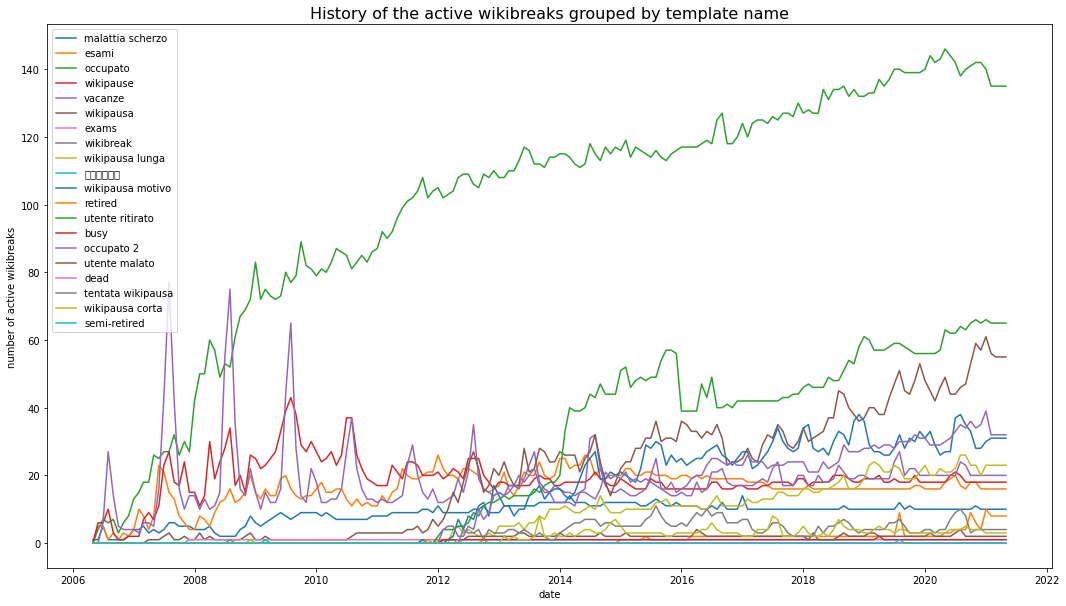

In [237]:
plt.figure(figsize=(18,10))
for wikibreak in breaks_history_wikibreak_count['wikibreak'].unique():
    wb = breaks_history_wikibreak_count_cleaned[breaks_history_wikibreak_count_cleaned['wikibreak'] == wikibreak]
    plt.plot(wb['date'], wb['count'], label = wikibreak)
plt.legend()
plt.title('History of the active wikibreaks grouped by template name', fontsize=16)
plt.ylabel('number of active wikibreaks')
plt.xlabel('date')
plt.show()

In [238]:
fig = px.line(breaks_history_wikibreak_count_cleaned, x='date', y='count', color='wikibreak', title='History of the active wikibreaks grouped by template name')
fig.show()

In [239]:
breaks_history_category_count = breaks_history[['year', 'month', 'subcategory', 'categories']]
breaks_history_category_count.head()

,year,month,subcategory,categories
0,2006,5,user mental health,"[health related, mental]"
1,2006,6,wikibreak,[break]
2,2006,6,wikibreak,[break]
3,2006,6,wikibreak,[break]
4,2006,6,exams,[break]


In [240]:
breaks_history_category_count_refactored = list()
for i, row in breaks_history_category_count.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        breaks_history_category_count_refactored.append(new_row)
breaks_history_category_count_refactored = pd.DataFrame(breaks_history_category_count_refactored).reset_index(drop=True)
breaks_history_category_count_refactored.head()

,year,month,subcategory,category
0,2006,5,user mental health,health related
1,2006,5,user mental health,mental
2,2006,6,wikibreak,break
3,2006,6,wikibreak,break
4,2006,6,wikibreak,break


In [241]:
breaks_history_category_count_refactored = breaks_history_category_count_refactored
breaks_history_category_count_refactored['count'] = 1
breaks_history_category_count_refactored = breaks_history_category_count_refactored[['year', 'month', 'category', 'count']].groupby(['year', 'month', 'category']).count().reset_index().sort_values(['year', 'month'], ascending=True)
breaks_history_category_count_refactored['date'] = pd.to_datetime(breaks_history_category_count_refactored[['year','month']].assign(day=1)).dt.date
breaks_history_category_count_refactored.head()

,year,month,category,count,date
0,2006,5,health related,1,2006-05-01
1,2006,5,mental,1,2006-05-01
2,2006,6,break,11,2006-06-01
3,2006,6,health related,1,2006-06-01
4,2006,6,mental,5,2006-06-01


In [242]:
breaks_history_category_count_refactored.tail()

,year,month,category,count,date
652,2021,4,other,73,2021-04-01
653,2021,5,break,171,2021-05-01
654,2021,5,health related,12,2021-05-01
655,2021,5,mental,178,2021-05-01
656,2021,5,other,73,2021-05-01


In [243]:
breaks_history_category_count_refactored.shape

(657, 5)

In [244]:
breaks_history_wikibreak_count.describe()

,year,month,count
count,2197.000000,2197.000000,2197.000000
mean,2014.816568,6.455166,20.887119
std,3.922117,3.452569,28.915051
min,2006.000000,1.000000,1.000000
25%,2012.000000,3.000000,3.000000
50%,2015.000000,6.000000,13.000000
75%,2018.000000,9.000000,23.000000
max,2021.000000,12.000000,146.000000


#### Clean counter

In [245]:
breaks_history_category_count_refactored_cleaned = list()
for date in breaks_history_category_count_refactored['date'].unique():
    for cat in categories:
        elem = breaks_history_category_count_refactored.loc[(breaks_history_category_count_refactored['date'] == date) & (breaks_history_category_count_refactored['category'] == cat)]
        if elem.empty:
            breaks_history_category_count_refactored_cleaned.append([date.year, date.month, cat, 0, date])
        else:
            breaks_history_category_count_refactored_cleaned.append(np.array(elem)[0])
breaks_history_category_count_refactored_cleaned = pd.DataFrame(breaks_history_category_count_refactored_cleaned).reset_index(drop=True).set_axis(['year', 'month', 'category', 'count', 'date'], axis=1)
breaks_history_category_count_refactored_cleaned.head()

,year,month,category,count,date
0,2006,5,break,0,2006-05-01
1,2006,5,other,0,2006-05-01
2,2006,5,mental,1,2006-05-01
3,2006,5,health related,1,2006-05-01
4,2006,6,break,11,2006-06-01


## Categories during Italian Wikipedia history

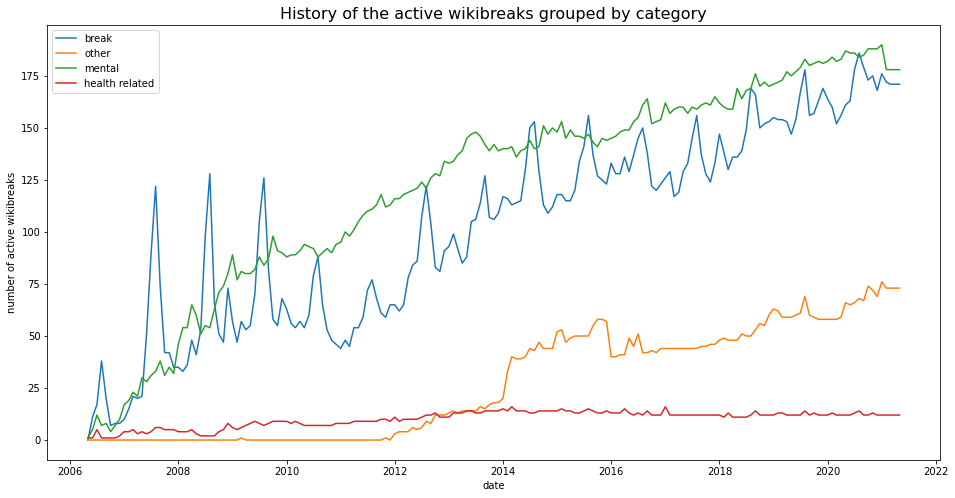

In [246]:
plt.figure(figsize=(16,8))
for cat in breaks_history_category_count_refactored_cleaned['category'].unique():
    category = breaks_history_category_count_refactored_cleaned[breaks_history_category_count_refactored_cleaned['category'] == cat]
    plt.plot(category['date'], category['count'], label = cat)
plt.legend()
plt.title('History of the active wikibreaks grouped by category', fontsize=16)
plt.ylabel('number of active wikibreaks')
plt.xlabel('date')
plt.show()

In [247]:
fig = px.line(breaks_history_category_count_refactored_cleaned, x='date', y='count', color='category', title='History of the active wikibreaks grouped by category')
fig.show()

## Line graphs normalized with respect to the active users of a specific month (subcategories)

In [248]:
breaks_history_subcategory_count_per_month = breaks_history_per_month
breaks_history_subcategory_count_per_month['count'] = 1
breaks_history_subcategory_count_per_month = breaks_history_subcategory_count_per_month[['year', 'month', 'subcategory', 'count']].groupby(['year', 'month',  'subcategory']).count().reset_index().sort_values(['year', 'month'], ascending=True)
breaks_history_subcategory_count_per_month['date'] = pd.to_datetime(breaks_history_subcategory_count_per_month[['year','month']].assign(day=1)).dt.date
breaks_history_subcategory_count_per_month.head()

,year,month,subcategory,count,date
0,2006,5,user mental health,1,2006-05-01
1,2006,6,busy,4,2006-06-01
2,2006,6,exams,5,2006-06-01
3,2006,6,wikibreak,6,2006-06-01
4,2006,7,busy,4,2006-07-01


In [249]:
breaks_history_subcategory_count_per_month.head()

,year,month,subcategory,count,date
0,2006,5,user mental health,1,2006-05-01
1,2006,6,busy,4,2006-06-01
2,2006,6,exams,5,2006-06-01
3,2006,6,wikibreak,6,2006-06-01
4,2006,7,busy,4,2006-07-01


Data cleaning

In [250]:
breaks_history_subcategory_count_per_month_refactored_cleaned = list()
for date in breaks_history_subcategory_count_per_month['date'].unique():
    for sub in subcategories:
        elem = breaks_history_subcategory_count_per_month.loc[(breaks_history_subcategory_count_per_month['date'] == date) & (breaks_history_subcategory_count_per_month['subcategory'] == sub)]
        if elem.empty:
            breaks_history_subcategory_count_per_month_refactored_cleaned.append([date.year, date.month, sub, 0, date])
        else:
            # divide the count by the number of active users in that month
            if np.array(elem)[0][1] < 10:
                month = '0{}'.format(np.array(elem)[0][1])
            else:
                month = '{}'.format(np.array(elem)[0][1])
            year = np.array(elem)[0][0]
            try:
                active_users = active_users_amount['per_mese']['{}_{}'.format(year, month)]
            except:
                active_users = 1 # no users were active
            prev = np.array(elem)[0][3]
            elem_refactored = elem.copy()
            elem_refactored['count'] = elem_refactored['count'].div(active_users) * 100
            breaks_history_subcategory_count_per_month_refactored_cleaned.append(np.array(elem_refactored)[0])
breaks_history_subcategory_count_per_month_refactored_cleaned = pd.DataFrame(breaks_history_subcategory_count_per_month_refactored_cleaned).reset_index(drop=True).set_axis(['year', 'month', 'subcategory', 'count', 'date'], axis=1)
breaks_history_subcategory_count_per_month_refactored_cleaned.head()

,year,month,subcategory,count,date
0,2006,5,exams,0.0,2006-05-01
1,2006,5,wikibreak,0.0,2006-05-01
2,2006,5,vacation,0.0,2006-05-01
3,2006,5,retired,0.0,2006-05-01
4,2006,5,busy,0.0,2006-05-01


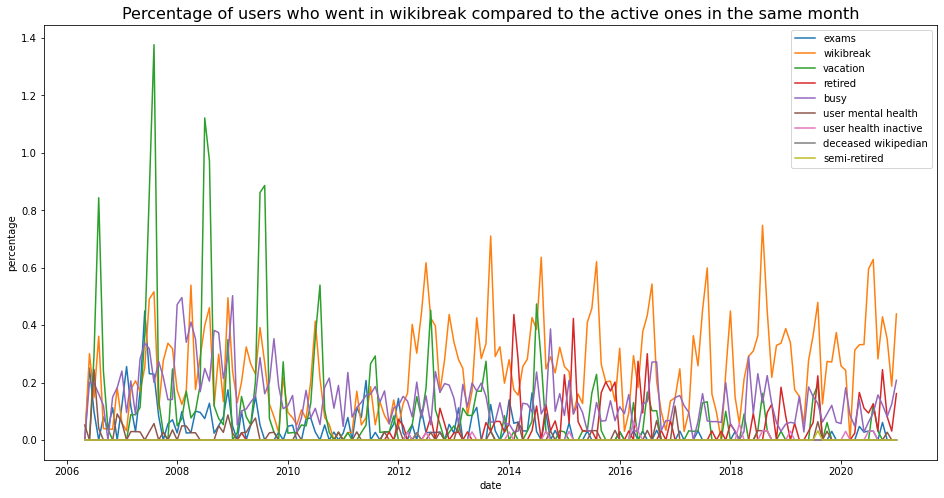

In [251]:
plt.figure(figsize=(16,8))
for sub in breaks_history_subcategory_count_per_month_refactored_cleaned['subcategory'].unique():
    subcategory = breaks_history_subcategory_count_per_month_refactored_cleaned[breaks_history_subcategory_count_per_month_refactored_cleaned['subcategory'] == sub]
    # remove the last month because it is not completed
    subcategory = subcategory[:-1]
    plt.plot(subcategory['date'], subcategory['count'], label = sub)
plt.legend()
plt.title('Percentage of users who went in wikibreak compared to the active ones in the same month', fontsize=16)
plt.ylabel('percentage')
plt.xlabel('date')
plt.show()

## Line graphs normalized with respect to the active users of a specific month (categories)

In [252]:
breaks_history_category_count_per_month = list()
for i, row in breaks_history_per_month.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        breaks_history_category_count_per_month.append(new_row)
breaks_history_category_count_per_month = pd.DataFrame(breaks_history_category_count_per_month).reset_index(drop=True)
breaks_history_category_count_per_month.head()

,year,month,subcategory,wikibreak,count,category
0,2006,5,user mental health,malattia scherzo,1,health related
1,2006,5,user mental health,malattia scherzo,1,mental
2,2006,6,wikibreak,wikipause,1,break
3,2006,6,wikibreak,wikipause,1,break
4,2006,6,wikibreak,wikipause,1,break


In [253]:
breaks_history_category_count_per_month_refactored = breaks_history_category_count_per_month
breaks_history_category_count_per_month_refactored['count'] = 1
breaks_history_category_count_per_month_refactored = breaks_history_category_count_per_month_refactored[['year', 'month', 'category', 'count']].groupby(['year', 'month', 'category']).count().reset_index().sort_values(['year', 'month'], ascending=True)
breaks_history_category_count_per_month_refactored['date'] = pd.to_datetime(breaks_history_category_count_per_month_refactored[['year','month']].assign(day=1)).dt.date
breaks_history_category_count_per_month_refactored.head()

,year,month,category,count,date
0,2006,5,health related,1,2006-05-01
1,2006,5,mental,1,2006-05-01
2,2006,6,break,11,2006-06-01
3,2006,6,mental,4,2006-06-01
4,2006,7,break,11,2006-07-01


Data cleaning

In [254]:
breaks_history_category_count_per_month_refactored_cleaned = list()
for date in breaks_history_category_count_per_month_refactored['date'].unique():
    for cat in categories:
        elem = breaks_history_category_count_per_month_refactored.loc[(breaks_history_category_count_per_month_refactored['date'] == date) & (breaks_history_category_count_per_month['category'] == cat)]
        if elem.empty:
            breaks_history_category_count_per_month_refactored_cleaned.append([date.year, date.month, cat, 0, date])
        else:
            # divide the count by the number of active users in that month
            if np.array(elem)[0][1] < 10:
                month = '0{}'.format(np.array(elem)[0][1])
            else:
                month = '{}'.format(np.array(elem)[0][1])
            year = np.array(elem)[0][0]
            try:
                active_users = active_users_amount['per_mese']['{}_{}'.format(year, month)]
            except:
                active_users = 1 # no users were active
            prev = np.array(elem)[0][3]
            elem_refactored = elem.copy()
            elem_refactored['count'] = elem_refactored['count'].div(active_users) * 100
            breaks_history_category_count_per_month_refactored_cleaned.append(np.array(elem_refactored)[0])
breaks_history_category_count_per_month_refactored_cleaned = pd.DataFrame(breaks_history_category_count_per_month_refactored_cleaned).reset_index(drop=True).set_axis(['year', 'month', 'category', 'count', 'date'], axis=1)
breaks_history_category_count_per_month_refactored_cleaned.head()

,year,month,category,count,date
0,2006,5,break,0.000000,2006-05-01
1,2006,5,other,0.000000,2006-05-01
2,2006,5,mental,0.052083,2006-05-01
3,2006,5,health related,0.052083,2006-05-01
4,2006,6,break,0.551655,2006-06-01


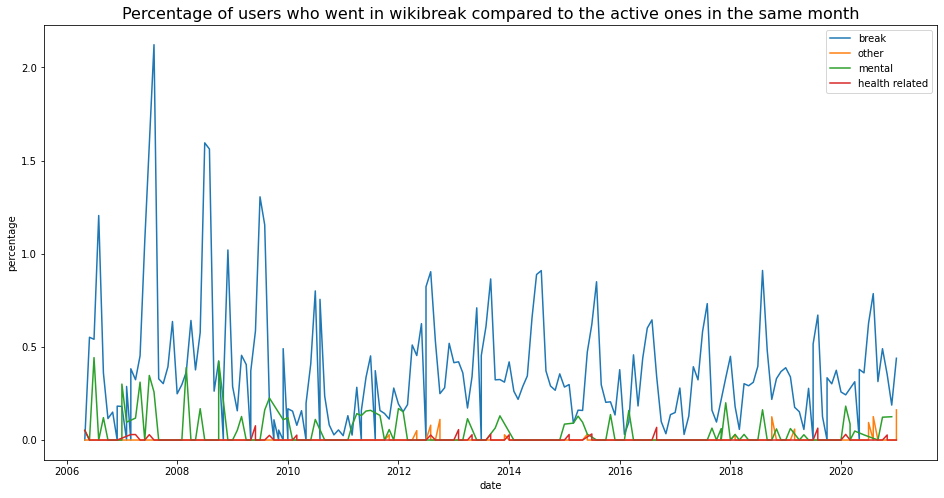

In [255]:
plt.figure(figsize=(16,8))
for cat in breaks_history_category_count_per_month_refactored_cleaned['category'].unique():
    category = breaks_history_category_count_per_month_refactored_cleaned[breaks_history_category_count_per_month_refactored_cleaned['category'] == cat]
    # remove the last month because it is not completed
    category = category[:-1]
    plt.plot(category['date'], category['count'], label = cat)
plt.legend()
plt.title('Percentage of users who went in wikibreak compared to the active ones in the same month', fontsize=16)
plt.ylabel('percentage')
plt.xlabel('date')
plt.show()

## Total number of times a certain template was used

In [256]:
# italian_wikibreaks_refactored_df.head()

In [257]:
wikibreak_used = italian_wikibreaks_refactored_df
wikibreak_used['count'] = 1
wikibreak_used = wikibreak_used[['wikibreak', 'count']].groupby('wikibreak').count().reset_index().sort_values(['count'], ascending=False)
wikibreak_used.head()

,wikibreak,count
5,occupato,724
12,vacanze,650
18,wikipause,479
14,wikipausa,450
17,wikipausa motivo,315


In [258]:
wikibreak_used.shape

(20, 2)

In [259]:
wikibreak_used.describe()

,count
count,20.000000
mean,179.150000
std,227.536064
min,1.000000
25%,1.750000
50%,73.000000
75%,258.750000
max,724.000000


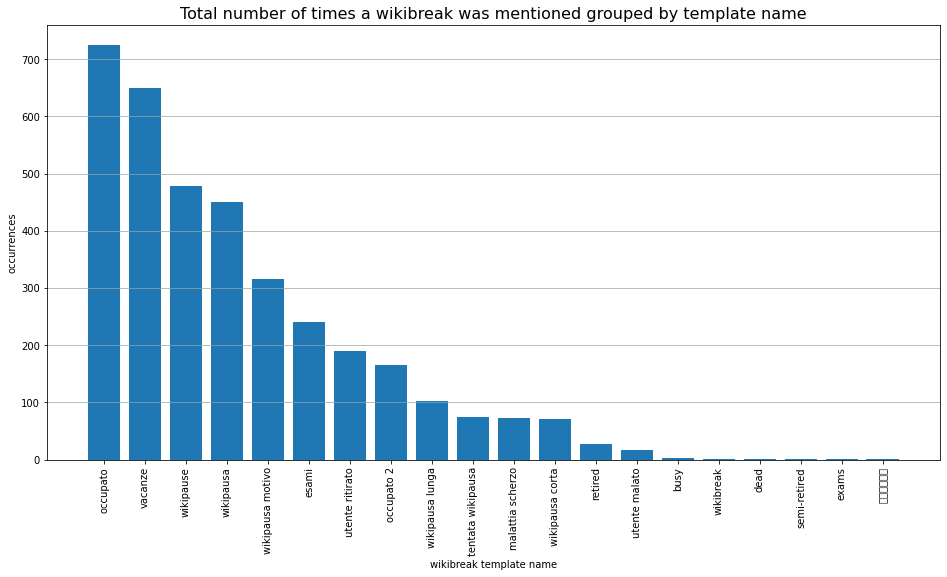

In [260]:
plt.figure(figsize=(16,8))
plt.bar(wikibreak_used['wikibreak'], wikibreak_used['count'])
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.7)
plt.xticks(rotation='vertical')
plt.title('Total number of times a wikibreak was mentioned grouped by template name', fontsize=16)
plt.ylabel('occurrences')
plt.xlabel('wikibreak template name')
plt.show()

# THE NON RENDERING FONT IS https://www.wikidata.org/wiki/Q5848674
# retired

## Number of time a certain subcategory was mentioned

In [261]:
subcategory_used = italian_wikibreaks_refactored_df
subcategory_used['count'] = 1
subcategory_used = subcategory_used[['subcategory', 'count']].groupby('subcategory').count().reset_index().sort_values(['count'], ascending=False)
subcategory_used.head()

,subcategory,count
8,wikibreak,1492
0,busy,891
7,vacation,650
2,exams,241
3,retired,218


In [262]:
subcategory_used.shape

(9, 2)

In [263]:
subcategory_used.describe()

,count
count,9.000000
mean,398.111111
std,515.641941
min,1.000000
25%,17.000000
50%,218.000000
75%,650.000000
max,1492.000000


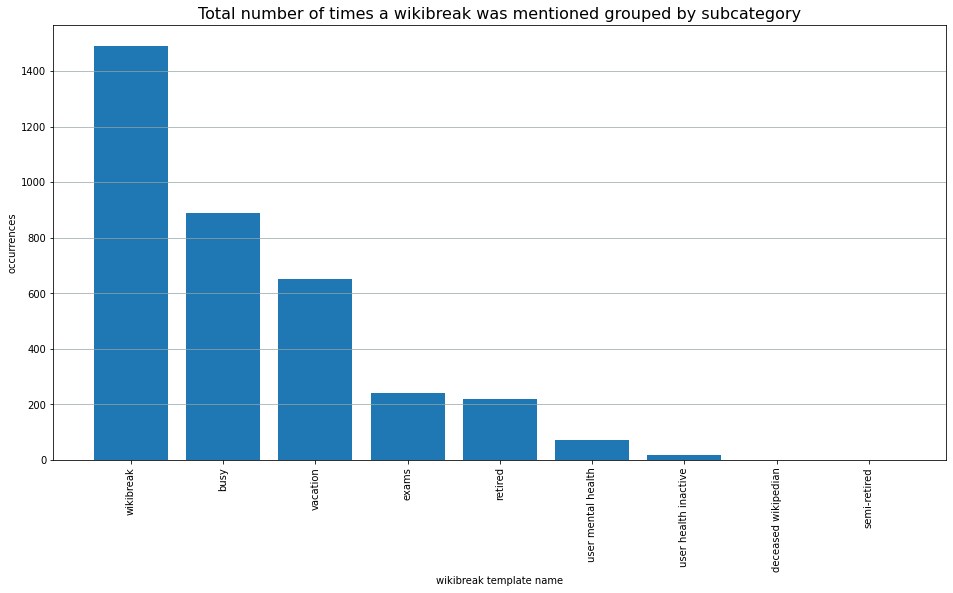

In [264]:
plt.figure(figsize=(16,8))
plt.bar(subcategory_used['subcategory'], subcategory_used['count'])
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.7)
plt.title('Total number of times a wikibreak was mentioned grouped by subcategory', fontsize=16)
plt.xticks(rotation='vertical')
plt.ylabel('occurrences')
plt.xlabel('wikibreak template name')
plt.show()

## Number of time a certain category was mentioned

In [265]:
category_used = still_in_breaks[['categories', 'name']]
category_used = list()
for i, row in italian_wikibreaks_refactored_df.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        category_used.append(new_row)
category_used = pd.DataFrame(category_used).reset_index(drop=True)
# category_used.head()

In [266]:
category_used['count'] = 1
category_used = category_used[['category', 'count']].groupby('category').count().reset_index().sort_values(['count'], ascending=False)
category_used.head()

,category,count
0,break,2383
2,mental,963
3,other,220
1,health related,89


In [267]:
category_used.shape

(4, 2)

In [268]:
category_used.describe()

,count
count,4.000000
mean,913.750000
std,1052.397699
min,89.000000
25%,187.250000
50%,591.500000
75%,1318.000000
max,2383.000000


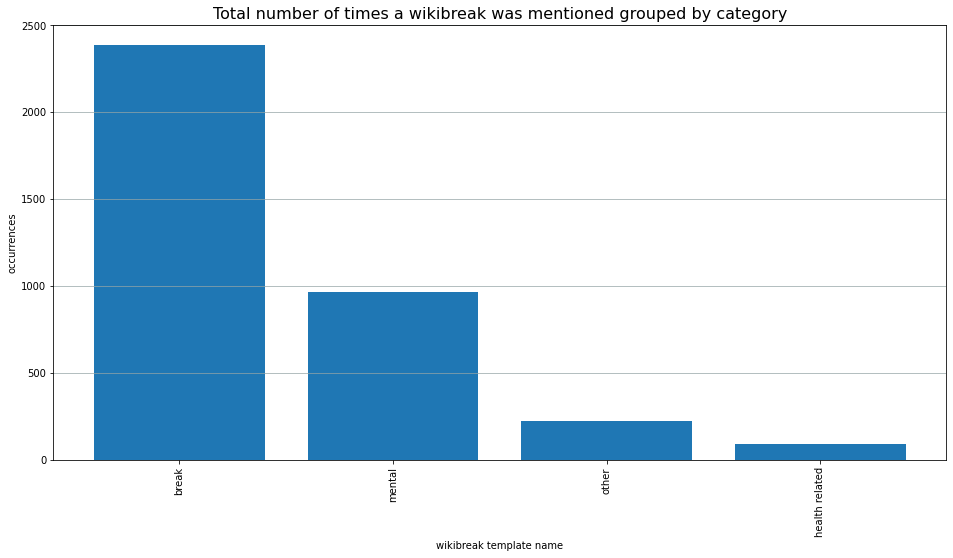

In [269]:
plt.figure(figsize=(16,8))
plt.bar(category_used['category'], category_used['count'])
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.7)
plt.xticks(rotation='vertical')
plt.title('Total number of times a wikibreak was mentioned grouped by category', fontsize=16)
plt.ylabel('occurrences')
plt.xlabel('wikibreak template name')
plt.show()

 ## Number of users who went multiples times in wikibreak (using the same template)

In [270]:
# italian_wikibreaks_refactored_df.head()

In [271]:
users_multiple_times_wikibreak = italian_wikibreaks_refactored_df
users_multiple_times_wikibreak['count'] = 1
# users_multiple_times_wikibreak.head()

In [272]:
users_multiple_times_wikibreak = users_multiple_times_wikibreak[['name', 'wikibreak', 'count']].groupby(['name', 'wikibreak']).count().reset_index()
# users_multiple_times_wikibreak.head()

In [273]:
total_users = italian_wikibreaks_df.shape[0]
total_users

1386

In [274]:
users_multiple_times_wikibreak = users_multiple_times_wikibreak.loc[users_multiple_times_wikibreak['count'] >= 2]
# users_multiple_times_wikibreak.head()

In [275]:
total_users_multiple = users_multiple_times_wikibreak.shape[0]
total_users_multiple

679

In [276]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_users_multiple, 'label': 'single time'}
row_multiple = {'total': total_users_multiple, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,707,single time
1,679,multiple times


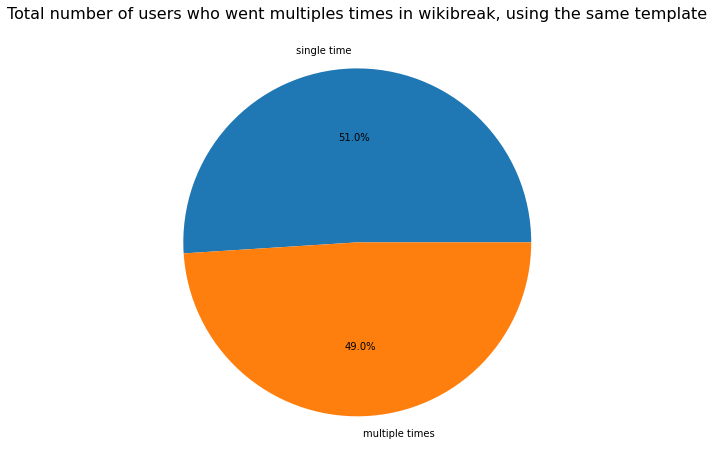

In [277]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using the same template', fontsize=16)
plt.show()

### Remove ambiguous users 

In [278]:
users_multiple_times_wikibreak_not_ambiguous = italian_wikibreaks_refactored_df
users_multiple_times_wikibreak_not_ambiguous = users_multiple_times_wikibreak_not_ambiguous.loc[users_multiple_times_wikibreak_not_ambiguous['ambiguous'] == False, ['name', 'wikibreak']]
users_multiple_times_wikibreak_not_ambiguous['count'] = 1
# users_multiple_times_wikibreak_not_ambiguous.head()

In [279]:
users_multiple_times_wikibreak_not_ambiguous.shape

(3023, 3)

In [280]:
users_multiple_times_wikibreak_not_ambiguous = users_multiple_times_wikibreak_not_ambiguous[['name', 'wikibreak', 'count']].groupby(['name', 'wikibreak']).count().reset_index()
# users_multiple_times_wikibreak_not_ambiguous.head()

In [281]:
users_multiple_times_wikibreak_not_ambiguous = users_multiple_times_wikibreak_not_ambiguous.loc[users_multiple_times_wikibreak_not_ambiguous['count'] >= 2]
# users_multiple_times_wikibreak_not_ambiguous.head()

In [282]:
total_users_multiple_wikibreak_not_ambiguous = users_multiple_times_wikibreak_not_ambiguous.shape[0]
total_users_multiple_wikibreak_not_ambiguous

556

Still over the total amount of users

In [283]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_users_multiple_wikibreak_not_ambiguous, 'label': 'single time'}
row_multiple = {'total': total_users_multiple_wikibreak_not_ambiguous, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,830,single time
1,556,multiple times


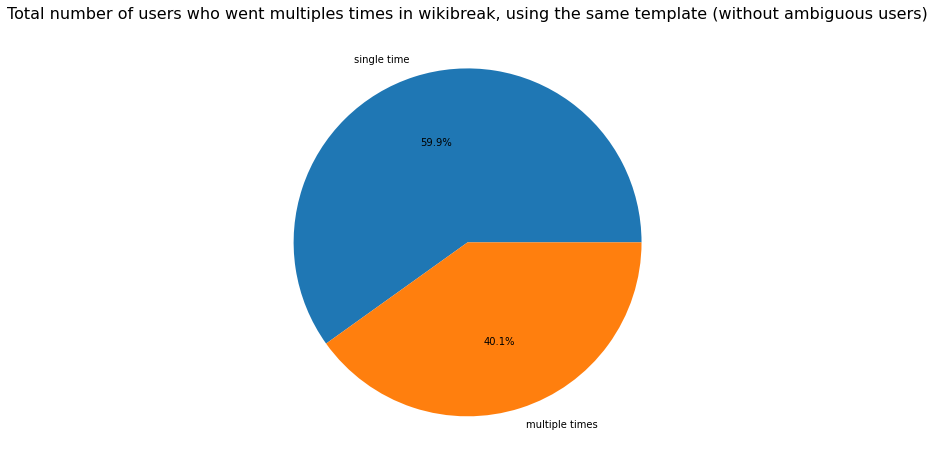

In [284]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using the same template (without ambiguous users)', fontsize=16)
plt.show()

 ## Number of users who went multiples times in wikibreak (using the same subcategory)

In [285]:
# italian_wikibreaks_refactored_df.head()

In [286]:
users_multiple_times_subcategory = italian_wikibreaks_refactored_df
users_multiple_times_subcategory['count'] = 1
# users_multiple_times_subcategory.head()

In [287]:
users_multiple_times_subcategory.shape

(3583, 11)

In [288]:
users_multiple_times_subcategory = users_multiple_times_subcategory[['name', 'subcategory', 'count']].groupby(['name', 'subcategory']).count().reset_index()
# users_multiple_times_subcategory.head()

In [289]:
users_multiple_times_subcategory = users_multiple_times_subcategory.loc[users_multiple_times_subcategory['count'] >= 2]
# users_multiple_times_subcategory.head()

In [290]:
total_users_multiple = users_multiple_times_wikibreak.shape[0]
total_users_multiple

679

In [291]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_users_multiple, 'label': 'single time'}
row_multiple = {'total': total_users_multiple, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,707,single time
1,679,multiple times


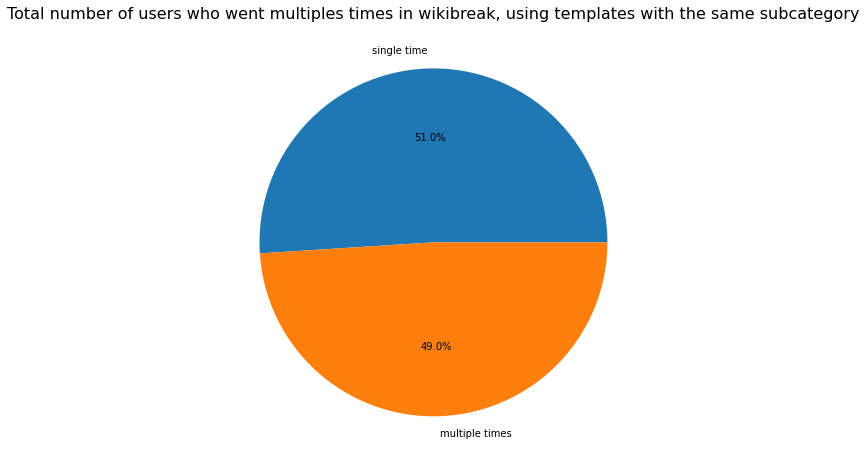

In [292]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using templates with the same subcategory', fontsize=16)
plt.show()

### Remove ambiguous users 

In [293]:
users_multiple_times_subcategory_not_ambiguous = italian_wikibreaks_refactored_df
users_multiple_times_subcategory_not_ambiguous = users_multiple_times_subcategory_not_ambiguous.loc[users_multiple_times_subcategory_not_ambiguous['ambiguous'] == False, ['name', 'subcategory']]
users_multiple_times_subcategory_not_ambiguous['count'] = 1
# users_multiple_times_subcategory_not_ambiguous.head()

In [294]:
users_multiple_times_subcategory_not_ambiguous.shape

(3023, 3)

In [295]:
users_multiple_times_subcategory_not_ambiguous = users_multiple_times_subcategory_not_ambiguous[['name', 'subcategory', 'count']].groupby(['name', 'subcategory']).count().reset_index()
# users_multiple_times_subcategory_not_ambiguous.head()

In [296]:
users_multiple_times_subcategory_not_ambiguous = users_multiple_times_subcategory_not_ambiguous.loc[users_multiple_times_subcategory_not_ambiguous['count'] >= 2]
# users_multiple_times_subcategory_not_ambiguous.head()

In [297]:
total_users_multiple_times_subcategory_not_ambiguous = users_multiple_times_subcategory_not_ambiguous.shape[0]
total_users_multiple_times_subcategory_not_ambiguous

579

Still over the total

In [298]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_users_multiple_times_subcategory_not_ambiguous, 'label': 'single time'}
row_multiple = {'total': total_users_multiple_times_subcategory_not_ambiguous, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,807,single time
1,579,multiple times


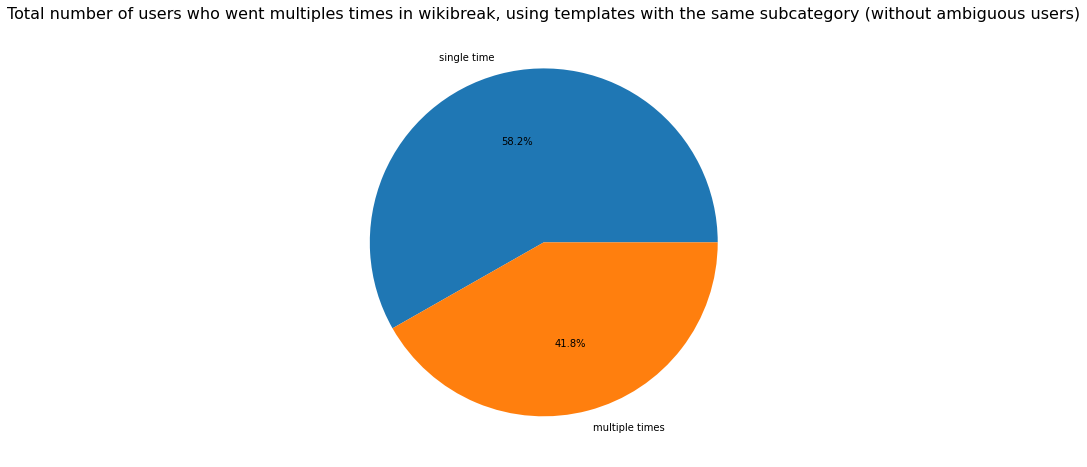

In [299]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using templates with the same subcategory (without ambiguous users)', fontsize=16)
plt.show()

 ## Number of users who went multiples times in wikibreak (using the same category)

In [300]:
# italian_wikibreaks_refactored_df.head()

#### Explicit the category

In [301]:
categories_multiple_times = italian_wikibreaks_refactored_df[['categories', 'name']]
categories_multiple_times_refactored = list()
for i, row in italian_wikibreaks_refactored_df.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        categories_multiple_times_refactored.append(new_row)
categories_multiple_times_refactored = pd.DataFrame(categories_multiple_times_refactored).reset_index(drop=True)
# categories_multiple_times_refactored.head()

In [302]:
categories_multiple_times.shape

(3583, 2)

In [303]:
categories_multiple_times_refactored = categories_multiple_times_refactored
categories_multiple_times_refactored['count'] = 1
# categories_multiple_times_refactored.head()

In [304]:
categories_multiple_times_refactored = categories_multiple_times_refactored[['name', 'category', 'count']].groupby(['name', 'category']).count().reset_index()
# categories_multiple_times_refactored.head()

In [305]:
categories_multiple_times_refactored = categories_multiple_times_refactored.loc[categories_multiple_times_refactored['count'] >= 2]
# categories_multiple_times_refactored.head()

In [306]:
total_category_multiple = categories_multiple_times_refactored.shape[0]
total_category_multiple

675

In [307]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_category_multiple, 'label': 'single time'}
row_multiple = {'total': total_category_multiple, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,711,single time
1,675,multiple times


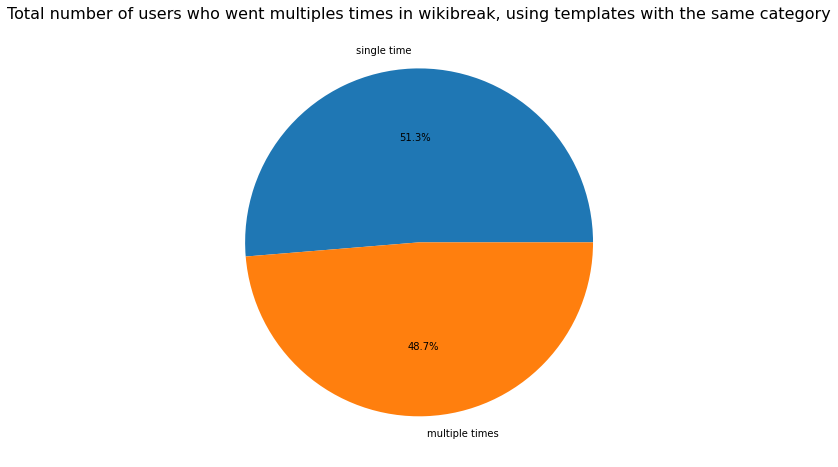

In [308]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using templates with the same category', fontsize=16)
plt.show()

### Remove ambiguous users 

In [309]:
users_multiple_times_category_not_ambiguous = italian_wikibreaks_refactored_df
users_multiple_times_category_not_ambiguous = users_multiple_times_category_not_ambiguous.loc[users_multiple_times_category_not_ambiguous['ambiguous'] == False, ['name', 'categories']]
users_multiple_times_category_not_ambiguous['count'] = 1
# users_multiple_times_category_not_ambiguous.head()

In [310]:
users_multiple_times_category_not_ambiguous_refactored = list()
for i, row in users_multiple_times_category_not_ambiguous.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        users_multiple_times_category_not_ambiguous_refactored.append(new_row)
users_multiple_times_category_not_ambiguous_refactored = pd.DataFrame(users_multiple_times_category_not_ambiguous_refactored).reset_index(drop=True)
# users_multiple_times_category_not_ambiguous_refactored.head()

In [311]:
users_multiple_times_category_not_ambiguous_refactored.shape

(3084, 3)

In [312]:
users_multiple_times_category_not_ambiguous_refactored = users_multiple_times_category_not_ambiguous_refactored[['name', 'category', 'count']].groupby(['name', 'category']).count().reset_index()
# users_multiple_times_category_not_ambiguous_refactored.head()

In [313]:
users_multiple_times_category_not_ambiguous_refactored = users_multiple_times_category_not_ambiguous_refactored.loc[users_multiple_times_category_not_ambiguous_refactored['count'] >= 2]
# users_multiple_times_category_not_ambiguous_refactored.head()

In [314]:
total_category_multiple_not_ambiguous = users_multiple_times_category_not_ambiguous_refactored.shape[0]
total_category_multiple_not_ambiguous

575

In [315]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_category_multiple_not_ambiguous, 'label': 'single time'}
row_multiple = {'total': total_category_multiple_not_ambiguous, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,811,single time
1,575,multiple times


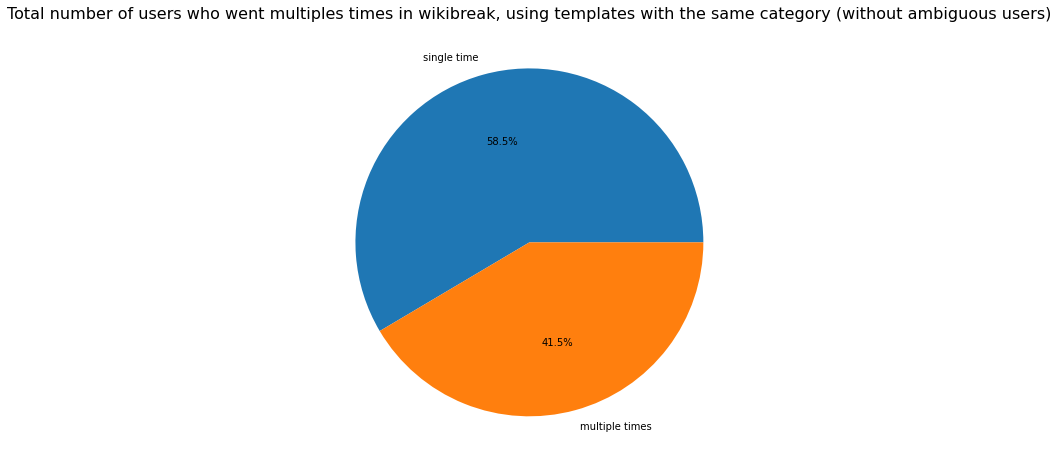

In [316]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using templates with the same category (without ambiguous users)', fontsize=16)

plt.show()

# Parameters analysis

In [317]:
# italian_wikibreaks_refactored_df.head()

## Explicit the parameters associated with the wikibreak considering each wikibreak of each user

In [318]:
parameters_explicited = list()
for i, row in italian_wikibreaks_refactored_df.iterrows():
    for el in row['parameters']:
        new_row = row
        new_row = new_row.drop('parameters')
        new_row['parameters'] = el['options']
        parameters_explicited.append(new_row)
parameters_explicited = pd.DataFrame(parameters_explicited).reset_index(drop=True)
# parameters_explicited.head()

### Wikibreak analysis

In [319]:
wikibreaks_parameters_df_list = list()

for wikibreak in wikibreaks:
    tmp_df = parameters_explicited.loc[parameters_explicited['wikibreak'] == wikibreak, ['name', 'parameters', 'count', 'wikibreak']]
    wikibreaks_parameters_df_list.append(tmp_df.reset_index(drop=True))

In [320]:
# wikibreaks_parameters_df_list[0].head()

Empty or filled parameters

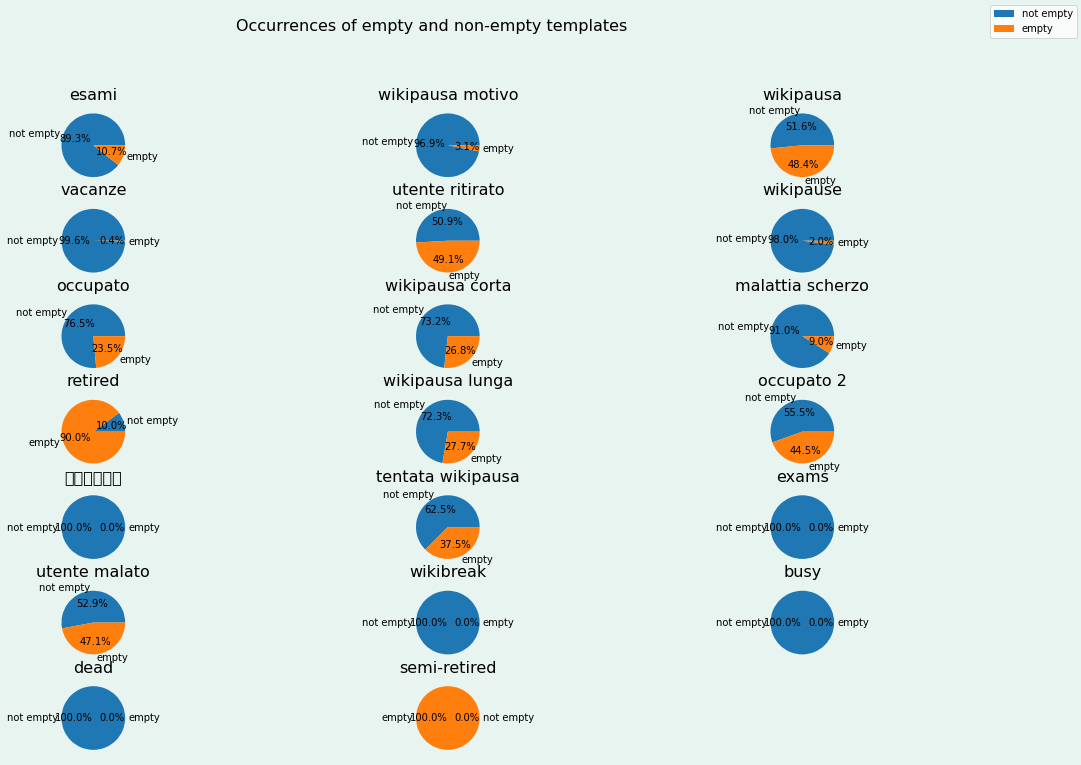

In [321]:
fig, axes = plt.subplots(math.ceil(len(wikibreaks)/3), 3, figsize=(18, 12), facecolor='#e8f4f0', squeeze=False)

last_axes = None


for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = wikibreaks_parameters_df_list[i]
    grouped = extracted.loc[extracted['parameters'] == {}, ['wikibreak', 'parameters', 'count']].groupby(['wikibreak']).count().reset_index(drop=True)
    total_empty = grouped['count']
    
    if not total_empty.empty:
        total_empty = total_empty[0]
    else:
        total_empty = 0
    
    # total empty over total
    row_total = {'total': extracted.shape[0] - total_empty, 'label': 'not empty'}
    row_empty = {'total': total_empty, 'label': 'empty'}
    rows = [row_total, row_empty]
    percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
    
    # figure
    ax = axes[i // 3, i % 3]
    ax.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
    ax.set_title(wikibreak, fontsize=16)
    
    last_axes = i % 3
    
    
for i in range((math.ceil(len(wikibreaks)/3) - 1) * 3 + last_axes + 1, math.ceil(len(wikibreaks)/3) * 3):
    fig.delaxes(axes.flatten()[i])

    
fig.suptitle('Occurrences of empty and non-empty templates', fontsize=16)
fig.legend(['not empty', 'empty'])
plt.show()

Total filled over parameterized

In [322]:
total_without_parameters = parameters_explicited.loc[parameters_explicited['parameters'] == {}, ['wikibreak', 'parameters', 'count']]
total_without_parameters.head()

,wikibreak,parameters,count
0,esami,{},1
1,esami,{},1
2,wikipausa motivo,{},1
3,wikipausa,{},1
4,wikipausa,{},1


In [323]:
row_total = {'total': parameters_explicited.shape[0] - total_without_parameters.shape[0], 'label': 'not empty'}
row_empty = {'total': total_without_parameters.shape[0], 'label': 'empty'}
rows = [row_total, row_empty]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times.head()

,total,label
0,3623,not empty
1,833,empty


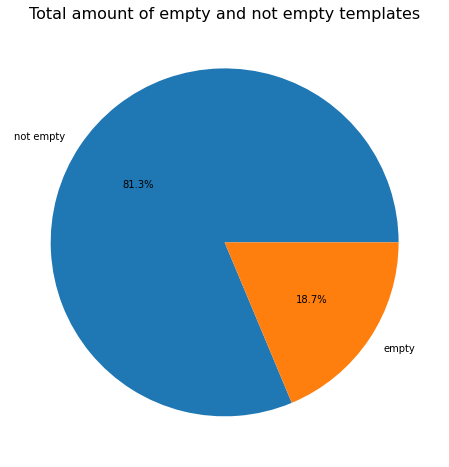

In [324]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total amount of empty and not empty templates', fontsize=16)
plt.show()

## Most used parameter per template

In [325]:
# dataframes for wikibreaks with param name and value
last_axes = None
most_used_parameters_per_template_df_list = list()

for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = wikibreaks_parameters_df_list[i]
    grouped = extracted.loc[extracted['parameters'] != {}, ['wikibreak', 'parameters', 'count']]
    most_used_parameters_per_template_list = list()
    for i, row in extracted.iterrows():
        for key, value in row['parameters'].items():
            new_row = row
            new_row = new_row.drop('parameters')
            new_row['param_name'] = key
            new_row['param_value'] = value
            most_used_parameters_per_template_list.append(new_row)
    most_used_parameters_per_template_df_list.append(pd.DataFrame(most_used_parameters_per_template_list).reset_index(drop=True))

# most_used_parameters_per_template_df_list[0].head()

In [326]:
most_used_parameters_per_template_df_list[0].shape

(247, 5)

In [327]:
most_used_parameters_per_template_grouped_df_list = list()
for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = most_used_parameters_per_template_df_list[i]
    if not extracted.empty:
        extracted['param_name'] = extracted['param_name'].str.strip()
        extracted = extracted[['count', 'wikibreak', 'param_name']].groupby(['param_name', 'wikibreak']).count().reset_index(drop=False)
    most_used_parameters_per_template_grouped_df_list.append(extracted)
most_used_parameters_per_template_grouped_df_list[0].head()

,param_name,wikibreak,count
0,1,esami,243
1,2,esami,3
2,motivo,esami,1


## Most used parameters per wikibreak

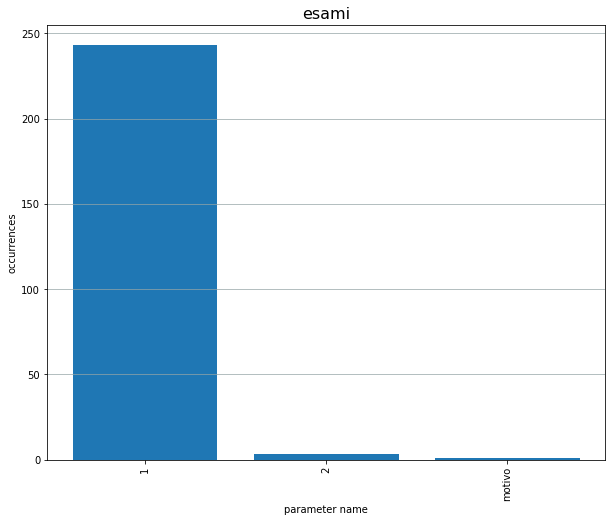

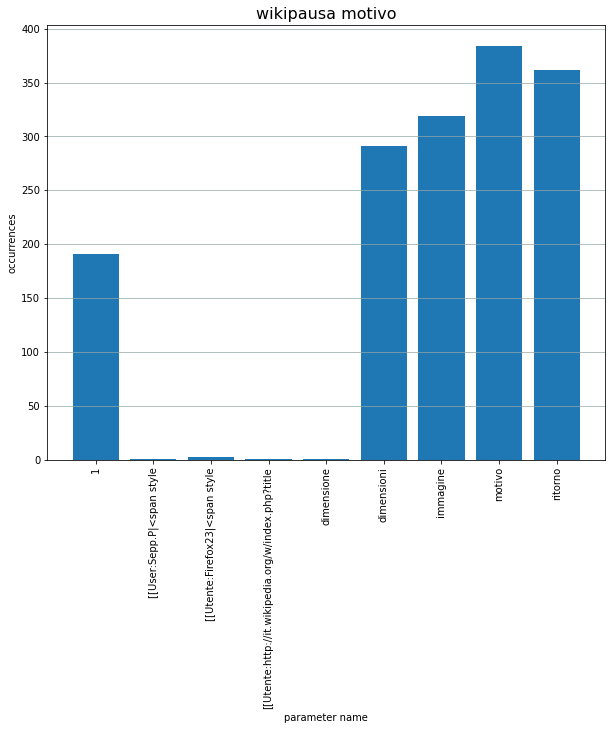

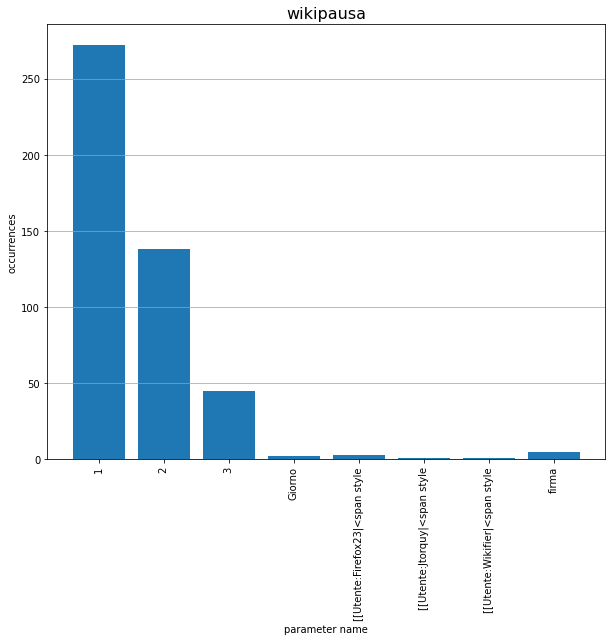

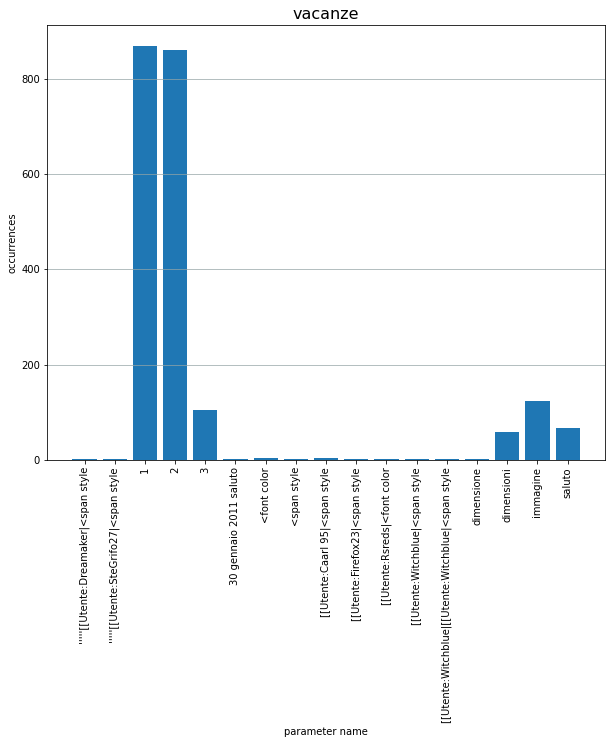

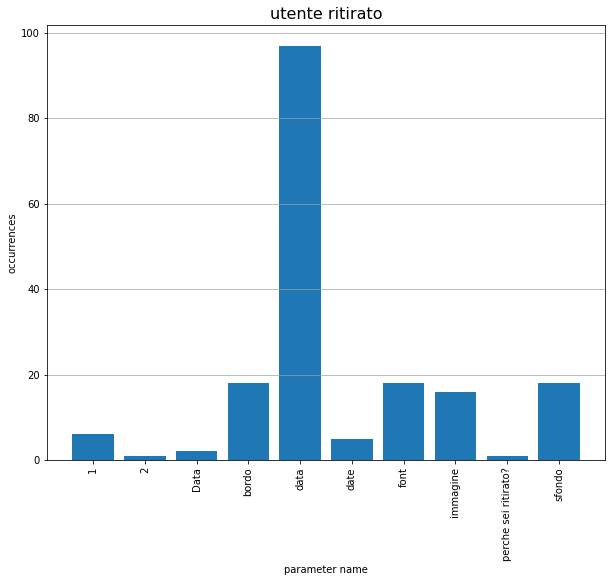

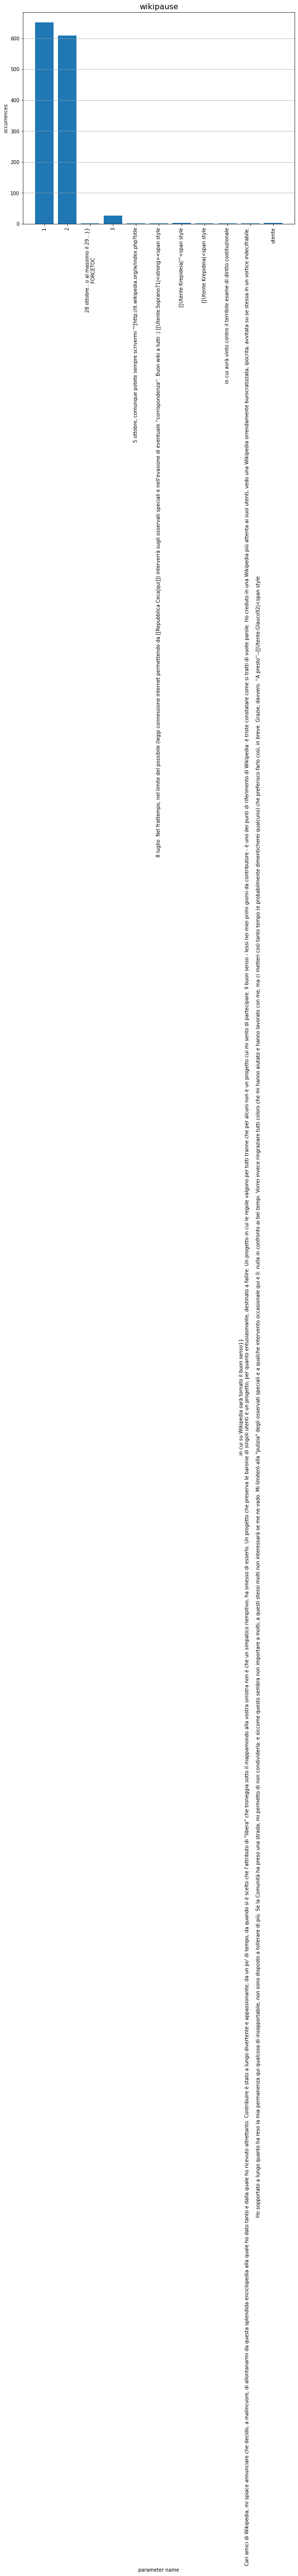

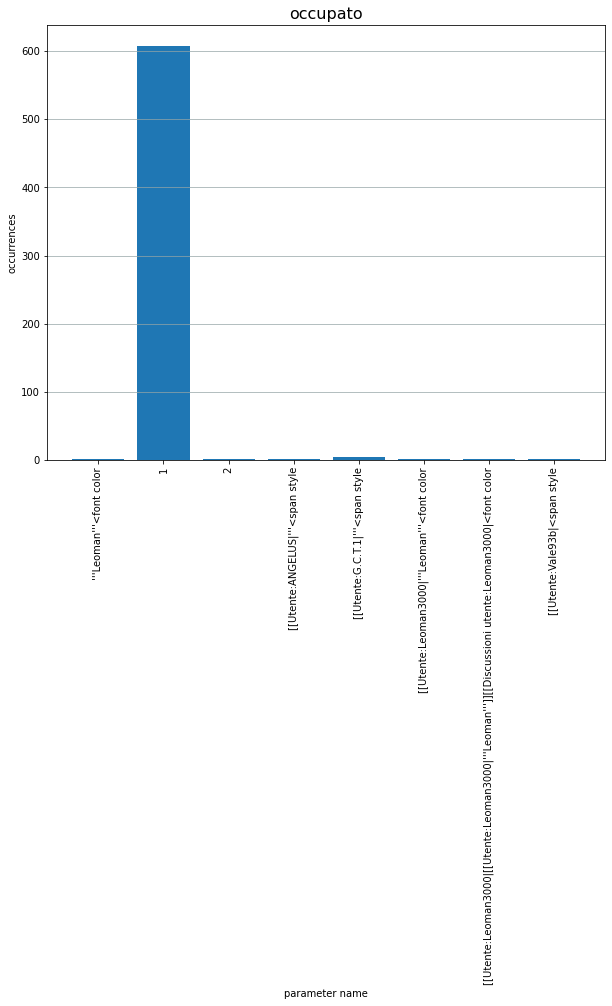

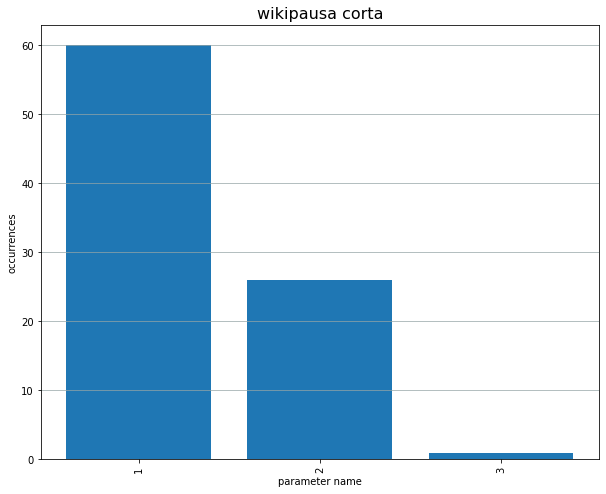

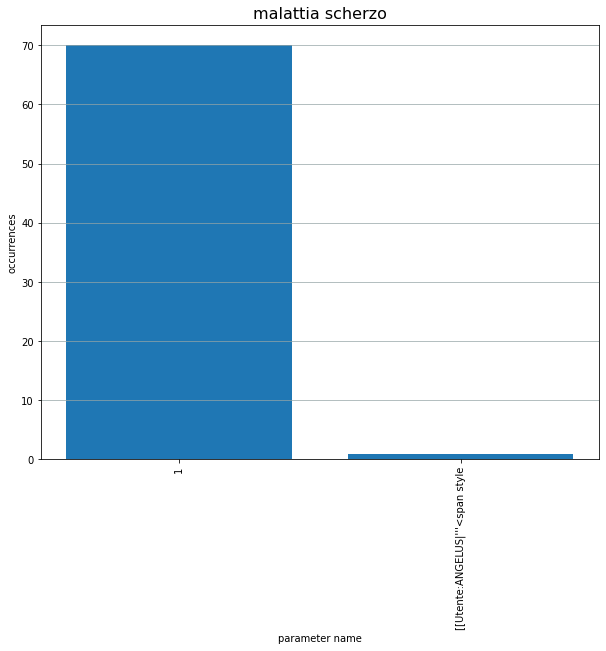

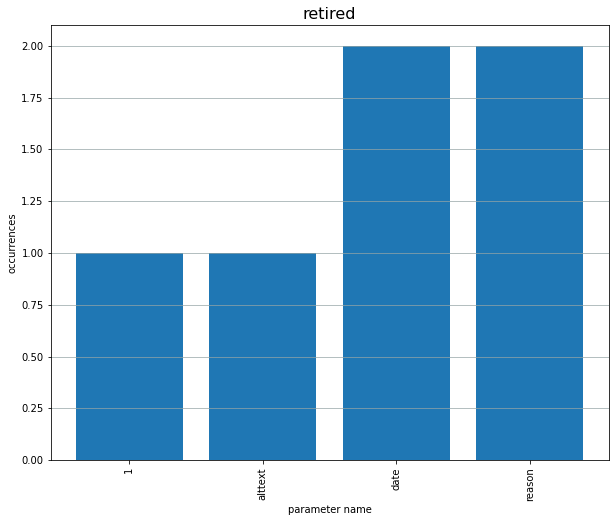

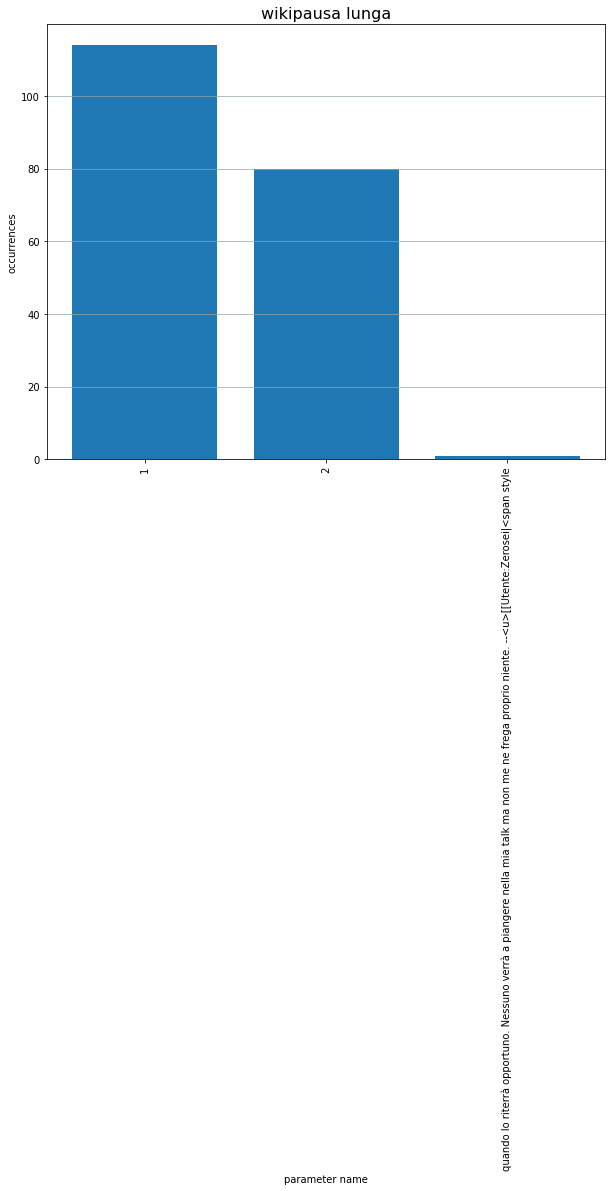

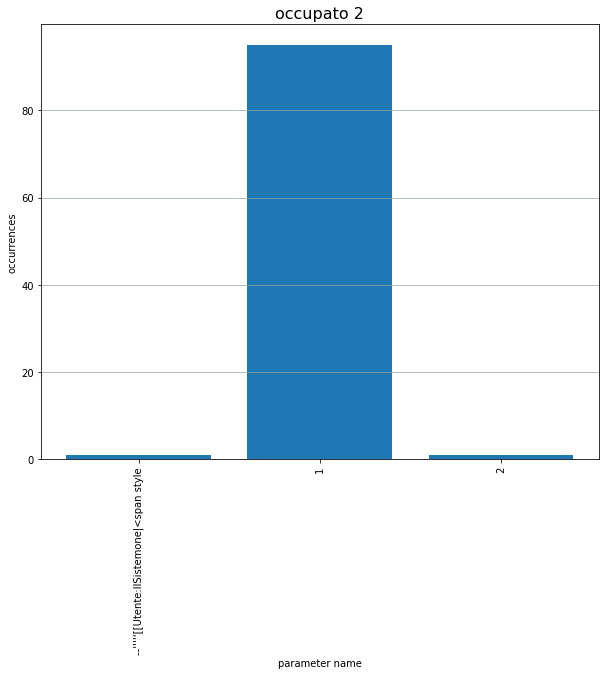

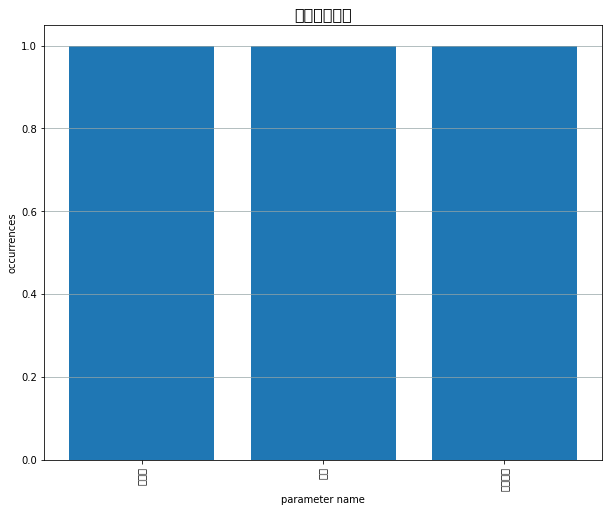

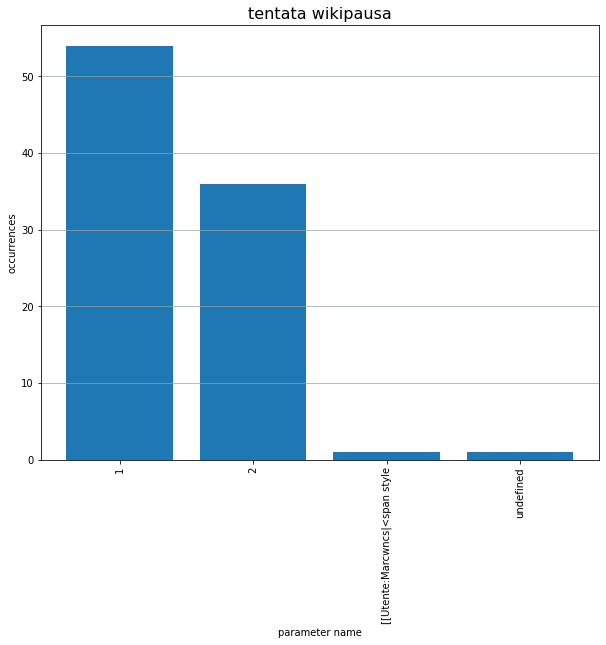

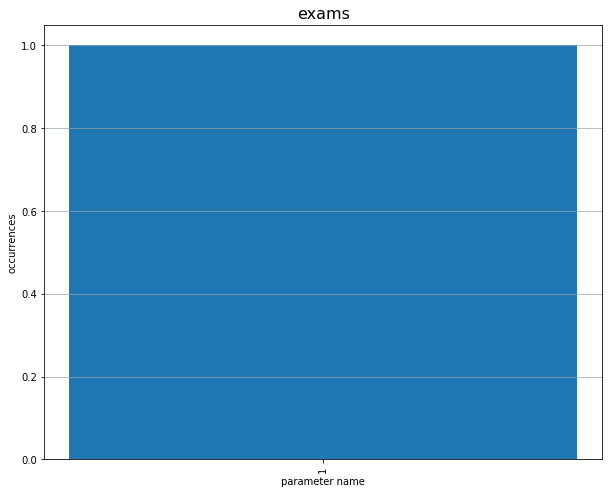

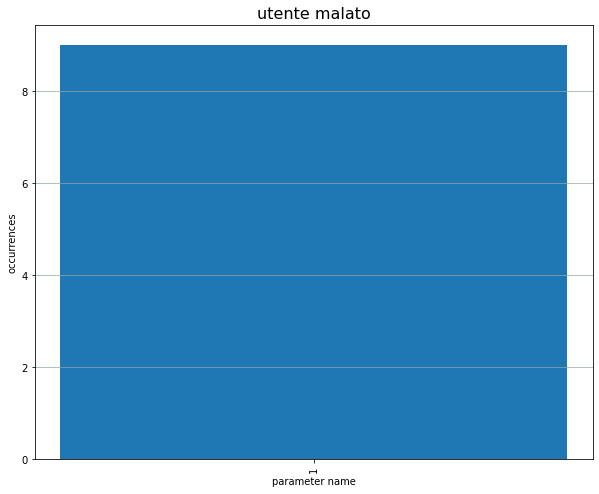

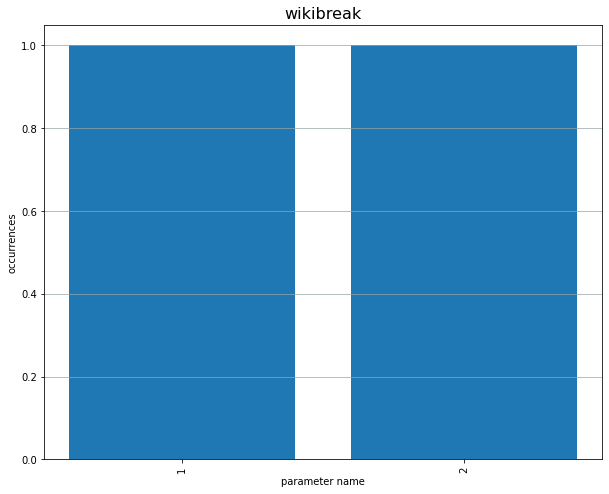

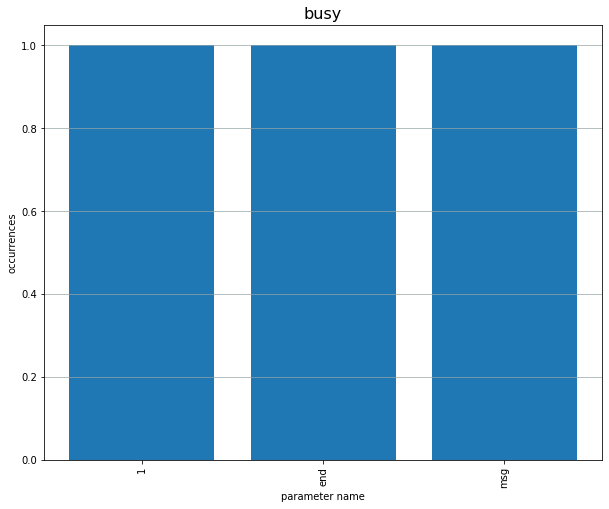

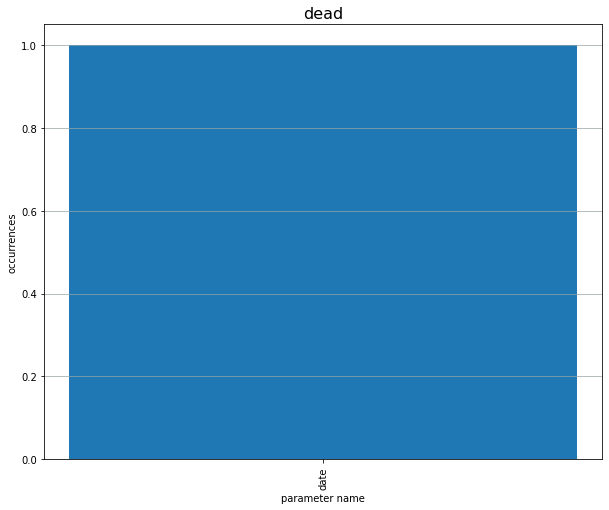

In [328]:
for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = most_used_parameters_per_template_grouped_df_list[i]
    
    if not extracted.empty:
        plt.figure(figsize=(10,8))
        plt.bar(most_used_parameters_per_template_grouped_df_list[i]['param_name'], most_used_parameters_per_template_grouped_df_list[i]['count'])
        plt.title(wikibreak, fontsize=16)
        plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.7)
        plt.xticks(rotation='vertical')
        plt.ylabel('occurrences')
        plt.xlabel('parameter name')
        plt.show()

## Some paramers in textual form

In [329]:
for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = most_used_parameters_per_template_df_list[i]
    if not extracted.empty:
        print('Template name: ', wikibreak)
        print('------------------------------------------------------------------')
        for i, val in extracted.sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
        print('------------------------------------------------------------------')

Template name:  esami
------------------------------------------------------------------
Param name: 1 param value: Mateusz occurrences: 1
Param name: 1 param value: [[Utente:EffeX2|EffeX2]] occurrences: 1
Param name: 1 param value: [[Utente:EffeX2|EffeX2]] occurrences: 1
Param name: 1 param value: [[Utente:B3t|B3t]] occurrences: 1
Param name: 1 param value: [[Utente:B3t|B3t]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:AnnaLety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:AnnaLety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Gambo7|Gambo7]] occurrences: 1
Param name: 1 param value: DoppioM occurr

Param name: 1 param value: [[Utente:InfattiVedeteCheViDice|InfattiVedeteCheViDice]] occurrences: 1
Param name: 1 param value: [[Utente:InfattiVedeteCheViDice|InfattiVedeteCheViDice]] occurrences: 1
Param name: 1 param value: [[Utente:InfattiVedeteCheViDice|InfattiVedeteCheViDice]] occurrences: 1
Param name: 1 param value: [[Utente:DigitalLegends|Martina]] occurrences: 1
Param name: 1 param value: [[Utente:DigitalLegends|DigitalLegends]] occurrences: 1
Param name: 1 param value: [[Utente:DigitalLegends|Martina]] occurrences: 1
Param name: 1 param value: [[Utente:Tooby|Tooby]] occurrences: 1
Param name: 1 param value: [[Utente:Tooby|Tooby]] occurrences: 1
Param name: 1 param value: Silvestro occurrences: 1
Param name: 1 param value: Silvestro occurrences: 1
Param name: 1 param value: [[Utente:Bizio|Bizio]] occurrences: 1
Param name: 1 param value: [[Utente:Bizio|Bizio]] occurrences: 1
Param name: 1 param value: Janette occurrences: 1
Param name: 1 param value: [[Utente:Hanyell29|Hanyell2

Param name: 1 param value: [[Utente:Francescoluciano93|Francescoluciano93]] occurrences: 1
Param name: 1 param value: [[Utente:Francescoluciano93|Francescoluciano93]] occurrences: 1
Param name: 1 param value: [[Utente:MapiVanPelt|mapi]]
 occurrences: 1
Param name: 1 param value: [[Utente:MapiVanPelt|mapi]]
 occurrences: 1
Param name: 1 param value: [[Utente:MapiVanPelt|mapi]]
 occurrences: 1
Param name: 1 param value: [[Utente:MapiVanPelt|mapi]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dome|Dome]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dome|Dome]]	
 occurrences: 1
Param name: 1 param value: [[Utente:Elkelon|Elkelon]]
 occurrences: 1
Param name: 1 param value: [[Utente:Elkelon|Elkelon]]
 occurrences: 1
Param name: 1 param value: [[Utente:Picoz|Picoz]]
 occurrences: 1
Param name: 1 param value: [[Utente:Picoz|Picoz]]
 occurrences: 1
Param name: 1 param value: [[Utente:John michael dorian|Leonardo]] occurrences: 1
Param name: 1 param value: [[Utente:Dome|Dome]]
 oc

Param name: 1 param value:  [[Utente:Dave93b|Dave93b]] 
 occurrences: 1
Param name: 1 param value:  [[Utente:Dave93b|Dave93b]] 
 occurrences: 1
Param name: 1 param value: [[User:SurdusVII|SurdusVII]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]  occurrences: 1
Param name: 1 param value:  [[Utente:Dave93b|Dave93b]] 
 occurrences: 1
Param name: [[User:Sepp.P|<span style param value: "background:#30B0FF"><span style="color:green">'''Se'''</span><span style="color:white">'''pp'''</span></span>]][[User talk:Sepp.P|<span style="background:#30B0FF"><span style="color:red">'''.P'''</span></span>]]
 occurrences: 1
Param name: [[Utente:Firefox23|<span style param value: "color:red;">'''''Firefox'''''</span>]]
 occurrences: 1
Param name: [[Utente:Firefox23|<span style param value: "color:red;">'''''Firefox'''''</span>]]
 occurrences: 1
Param name: [[Utente:Firefox23|<span style param value: "color:red;">'''''Firefox'''''</span>]]
 occurrences: 1
Param name: [[Utente:http:

Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value: 70px occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value: 100px occurrences: 1
Param name: dimensioni param value: 100px occurrences: 1
Param name: dimensioni param value: 90px occurrences: 1
Param name: dimensioni param value: 90px occurrences: 1
Param name: dimensioni par

Param name: immagine param value:  Sleep.svg	
 occurrences: 1
Param name: immagine param value:  Sleep.svg	
 occurrences: 1
Param name: immagine param value:  
 occurrences: 1
Param name: immagine param value:  occurrences: 1
Param name: immagine param value: GClef.svg occurrences: 1
Param name: immagine param value: GClef.svg occurrences: 1
Param name: immagine param value: Icona de la Terrassa de la Taverna de la Viquipèdia.png occurrences: 1
Param name: immagine param value:  occurrences: 1
Param name: immagine param value:  occurrences: 1
Param name: immagine param value: GClef.svg occurrences: 1
Param name: immagine param value: Abduction.svg occurrences: 1
Param name: immagine param value: Abduction.svg occurrences: 1
Param name: immagine param value:  Nuvola Scottish flag.svg occurrences: 1
Param name: immagine param value:  Nuvola Scottish flag.svg occurrences: 1
Param name: immagine param value:  Nuvola apps bookcase.svg
 occurrences: 1
Param name: immagine param value:  Nuvol

Param name: immagine param value:  Beer mug.svg
 occurrences: 1
Param name: immagine param value:  Nuvola apps khangman.png
 occurrences: 1
Param name: immagine param value:  Sasha Grey Corruption 3.jpg
 occurrences: 1
Param name: immagine param value:  Sasha Grey Corruption 3.jpg
 occurrences: 1
Param name: immagine param value:  Sasha Grey Corruption 3.jpg
 occurrences: 1
Param name: immagine param value:  Sasha Grey Corruption 3.jpg
 occurrences: 1
Param name: immagine param value:  Sasha Grey Corruption 3.jpg
 occurrences: 1
Param name: immagine param value:  
 occurrences: 1
Param name: immagine param value:  
 occurrences: 1
Param name: immagine param value:  Nuvolaappsbookcase.svg
 occurrences: 1
Param name: immagine param value:  Nuvolaappsbookcase.svg
 occurrences: 1
Param name: immagine param value:  Nuvolaappsbookcase.svg
 occurrences: 1
Param name: immagine param value:  occurrences: 1
Param name: immagine param value:  occurrences: 1
Param name: immagine param value:  Nuvo

 occurrences: 1
Param name: motivo param value:  per una breve vacanza in montagna
 occurrences: 1
Param name: motivo param value:  per una breve vacanza
 occurrences: 1
Param name: motivo param value:  per un programma televisivo di suo interesse
 occurrences: 1
Param name: motivo param value:  per un programma televisivo e cena
 occurrences: 1
Param name: motivo param value:  per un programma televisivo e cena
 occurrences: 1
Param name: motivo param value:  per una pausa
 occurrences: 1
Param name: motivo param value:  godersi tutto il suo mese e mezzo di mare.
 occurrences: 1
Param name: motivo param value:  godersi tutto il suo mese e mezzo di mare.
 occurrences: 1
Param name: motivo param value:  per godersi tutto il suo mese e mezzo di mare.
 occurrences: 1
Param name: motivo param value:  per frequentare un corso di [[supercazzola|supercazzole]]
 occurrences: 1
Param name: motivo param value: per impegni nella sua vita reale (ebbene sì, ha una vita reale) occurrences: 1
Param n

Param name: motivo param value:  per dare gli ultimi esami, fare la tesi, tirocinio e altre cose
 occurrences: 1
Param name: motivo param value:  per dare gli ultimi esami, fare la tesi, tirocinio e altre cose
 occurrences: 1
Param name: motivo param value:  per dare gli ultimi esami, fare la tesi, tirocinio e altre cose
 occurrences: 1
Param name: motivo param value: a causa di impegni numerosi e gravosi (sic!)  occurrences: 1
Param name: motivo param value:  a causa di un infortunio alla spalla che gli rende scomodo l'utilizzo del pc, specialmente in scrittura occurrences: 1
Param name: motivo param value:  a partire dal 7 gennaio 2012 per motivi di studio  
 occurrences: 1
Param name: motivo param value:  a partire dal 7 gennaio 2012 perché non ha il tempo di poter contribuire all'enciclopedia  
 occurrences: 1
Param name: motivo param value:  perché non ha il tempo di poter contribuire all'enciclopedia  
 occurrences: 1
Param name: motivo param value: un ritiro spirituale occurrenc

Param name: motivo param value: per colpa del suo computer, vendutogli difettoso occurrences: 1
Param name: motivo param value: per colpa del suo computer, vendutogli difettoso occurrences: 1
Param name: motivo param value: per colpa del suo computer, vendutogli difettoso occurrences: 1
Param name: motivo param value: a causa dei suoi impegni lavorativi occurrences: 1
Param name: motivo param value:  a causa dei suoi impegni lavorativi
 occurrences: 1
Param name: motivo param value:  occurrences: 1
Param name: ritorno param value: nel sacco della Befana, o forse anche prima, ma solo per qualche visitina veloce... occurrences: 1
Param name: ritorno param value: nel sacco della Befana, o forse anche prima, ma solo per qualche visitina veloce... occurrences: 1
Param name: ritorno param value: fra ½ [[:en:FFF system|ftn]] occurrences: 1
Param name: ritorno param value: quando gli omini dell'assistenza tecnica avranno fatto il loro dovere occurrences: 1
Param name: ritorno param value: quan

Param name: ritorno param value:  entro 20 minuti
 occurrences: 1
Param name: ritorno param value:  alla fine delle vacanze. Ricorda però che PupyFaki farà comunque modifiche!
 occurrences: 1
Param name: ritorno param value:  alla fine delle vacanze. Ricorda però che PupyFaki farà comunque modifiche!
 occurrences: 1
Param name: ritorno param value:  alla fine delle vacanze. Ricorda però che PupyFaki farà comunque modifiche
 occurrences: 1
Param name: ritorno param value:  
 occurrences: 1
Param name: ritorno param value: tra qualche tempo. Ciò non toglie che possa sporadicamente passare da queste parti per rispondere ai messaggi occurrences: 1
Param name: ritorno param value: tra qualche tempo. Ciò non toglie che possa sporadicamente passare da queste parti per rispondere ai messaggi occurrences: 1
Param name: ritorno param value:  appena finito di sistemare la nuova dimora
 occurrences: 1
Param name: ritorno param value: presto (ma tanto sempre qua sto) occurrences: 1
Param name: rito

Param name: ritorno param value:  appena gli daranno un [[bastone di Asclepio]] da dare in testa ai vandali
 occurrences: 1
Param name: ritorno param value:  dopo il 17 giugno occurrences: 1
Param name: ritorno param value:  dopo il 23 giugno occurrences: 1
Param name: ritorno param value:  a fine luglio
 occurrences: 1
Param name: ritorno param value:  dopo Pasqua (si spera). Nel frattempo però continuerà a contribuire saltuarimente con piccoli edit, giusto per tenere in ordine gli OS
 occurrences: 1
Param name: ritorno param value:  in data indefinibile. Nel frattempo però continuerà a contribuire saltuarimente con piccoli edit, giusto per tenere in ordine gli OS e rispondere ai messaggi
 occurrences: 1
Param name: ritorno param value:  ai primi d'agosto, se ne avrà voglia e se non troverà l'Apocalisse sul lavoro
 occurrences: 1
Param name: ritorno param value:  in una data ad oggi indeterminata (ma farà di tanto in tanto piccoli edit mentalmente non impegnativi) occurrences: 1
Param

Param name: 1 param value: [[Utente:Seics|Seics]] occurrences: 1
Param name: 1 param value: [[Utente:Seics|Seics]] occurrences: 1
Param name: 1 param value: [[Utente:Seics|Seics]] occurrences: 1
Param name: 1 param value: [[Utente:Seics|Seics]] occurrences: 1
Param name: 1 param value: [[Utente:Seics|Seics]] occurrences: 1
Param name: 1 param value: [[Utente:Seics|Seics]] occurrences: 1
Param name: 1 param value: [[Utente:Seics|Seics]] occurrences: 1
Param name: 1 param value: '''Fidia 82''' occurrences: 1
Param name: 1 param value: '''Fidia 82''' occurrences: 1
Param name: 1 param value: Twice25 occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: 24 febbraio 2013 occurrences: 1
Param name: 1 param value: [[Discussioni utente:Adalingio|Adalingio]] occurrences: 1
Param name: 1 param value:

Param name: 1 param value: [[Utente:Wikiravenclaw|Wikiravenclaw]] occurrences: 1
Param name: 1 param value: [[Utente:Wikiravenclaw|Wikiravenclaw]] occurrences: 1
Param name: 1 param value: [[Utente:Wikiravenclaw|Wikiravenclaw]] occurrences: 1
Param name: 1 param value: [[Utente:JapanLove|JapanLove]] occurrences: 1
Param name: 1 param value: [[Utente:Stegit|Ha preso una pausa fino all']] occurrences: 1
Param name: 1 param value: [[Utente:Alkalin|Alkalin]] occurrences: 1
Param name: 1 param value: [[Utente:MDRS UwU|MDRS UwU]] occurrences: 1
Param name: 1 param value: [[Utente:MDRS UwU|MDRS UwU]] occurrences: 1
Param name: 1 param value: [[Utente:MDRS UwU|MDRS UwU]] occurrences: 1
Param name: 1 param value: [[Utente:SuperPaperoga%21|SuperPaperoga!]] occurrences: 1
Param name: 1 param value: [[Utente:SuperPaperoga%21|SuperPaperoga!]] occurrences: 1
Param name: 1 param value: ChemicalBit occurrences: 1
Param name: 1 param value: [[Utente:Gabrielemac|Gabrielemac]] occurrences: 1
Param name: 

Param name: 2 param value: che passa l'esame di promotore finanziario occurrences: 1
Param name: 2 param value: 24 agosto 2017 occurrences: 1
Param name: 2 param value: 24 agosto 2017 occurrences: 1
Param name: 2 param value: ...? occurrences: 1
Param name: 2 param value: 19 agosto siccome è in vacanza in Olanda occurrences: 1
Param name: 2 param value: che verrà ripristinato il file [[File:Esercito consolare polibiano III secAC.png]]. In alternativa si chiude qui la mia avventura Wikipediana occurrences: 1
Param name: 2 param value: 24 giugno 2013 occurrences: 1
Param name: 2 param value: 24 giugno 2013 occurrences: 1
Param name: 2 param value: 24 giugno 2013 occurrences: 1
Param name: 2 param value: 24 giugno 2013 occurrences: 1
Param name: 2 param value: 24 giugno 2013 occurrences: 1
Param name: 2 param value: 24 giugno 2013 occurrences: 1
Param name: 2 param value: 7 luglio 2013 occurrences: 1
Param name: 2 param value: 7 luglio 2013 occurrences: 1
Param name: 2 param value: 7 lugl

Param name: 2 param value: 31 febbraio 2050 occurrences: 1
Param name: 2 param value: 31 febbraio 2050 occurrences: 1
Param name: 2 param value: in cui i contributi saranno validati da un comitato redazionale di esperti e non lasciati in balia di sconosciuti o di troll occurrences: 1
Param name: 2 param value: in cui i contributi saranno validati da un comitato redazionale di esperti e non lasciati in balia di sconosciuti o di troll occurrences: 1
Param name: 2 param value: in cui i contributi saranno validati da un comitato redazionale di esperti e non lasciati in balia di sconosciuti o di troll occurrences: 1
Param name: 2 param value:  tra un paio di settimane occurrences: 1
Param name: 2 param value: ...? occurrences: 1
Param name: 2 param value: che ne avrà voglia occurrences: 1
Param name: 2 param value: : '''When all are CAPS and not a ball, to be a rock <small><sup>(exo)</sup></small> and not to roll ::)''' occurrences: 1
Param name: 2 param value:  che una materia base non sar

style="color:blue;">'''Explosive'''</span>]] - [[Discussioni utente: Explosive Ezio|<span style="color:red;">'''Ezio'''</span>]]</span> occurrences: 1
Param name: firma param value:  <span style="text-shadow:lightblue 0.118em 0.118em 0.118em; class=texhtml">[[Utente: Explosive Ezio|<span 
style="color:blue;">'''Explosive'''</span>]] - [[Discussioni utente: Explosive Ezio|<span style="color:red;">'''Ezio'''</span>]]</span> occurrences: 1
Param name: firma param value:  <span style="text-shadow:lightblue 0.118em 0.118em 0.118em; class=texhtml">[[Utente: Explosive Ezio|<span 
style="color:blue;">'''Explosive'''</span>]] - [[Discussioni utente: Explosive Ezio|<span style="color:red;">'''Ezio'''</span>]]</span> occurrences: 1
------------------------------------------------------------------
Template name:  vacanze
------------------------------------------------------------------
Param name: '''''[[Utente:Dreamaker|<span style param value: "font-family:Neuropol, serif; color:black;">Dreama

Param name: 1 param value: [[Utente:Maitland|Maitland]] occurrences: 1
Param name: 1 param value: [[Utente:Maitland|Maitland]] occurrences: 1
Param name: 1 param value: [[Utente:Maitland|Maitland]] occurrences: 1
Param name: 1 param value: Tizio X occurrences: 1
Param name: 1 param value: ''Alessio'' alias S141739 occurrences: 1
Param name: 1 param value: Valerinik occurrences: 1
Param name: 1 param value: Valerinik occurrences: 1
Param name: 1 param value: Valerinik occurrences: 1
Param name: 1 param value: Valerinik occurrences: 1
Param name: 1 param value: Valerinik occurrences: 1
Param name: 1 param value: Valerinik occurrences: 1
Param name: 1 param value: [[Utente:Zeuslnx|Zeuslnx]] occurrences: 1
Param name: 1 param value: [[Utente:Zeuslnx|Zeuslnx]] occurrences: 1
Param name: 1 param value: [[Utente:Pequod76|Pequod76]]
 occurrences: 1
Param name: 1 param value: [[Utente:Lissen|Lissen]] occurrences: 1
Param name: 1 param value: [[Utente:Lissen|Lissen]] occurrences: 1
Param name: 1

Param name: 1 param value: [[Utente:Furbozio|Furbozio]]
 occurrences: 1
Param name: 1 param value: [[Utente:Chia.gio|Chia.gio]]
 occurrences: 1
Param name: 1 param value: [[Utente:Chia.gio|Chia.gio]]
 occurrences: 1
Param name: 1 param value: il kiado occurrences: 1
Param name: 1 param value: il kiado occurrences: 1
Param name: 1 param value: Rojelio occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano]] occurrences: 1
Param name: 1 param value: [[Utente:Yoruno|yoruno]] occurrences: 1
Param name: 1 param value: [[Utente:Yoruno|yoruno]] occurrences: 1
Param name: 1 param value: [[Utente:Yoruno|yoruno]] occurrences: 1
Param name: 1 param value: [[Utente:Yoruno|yoruno]] occurrences: 1
Param name: 1 param value: [[Utente:Giannib|GianniB]] occurrences: 1
Param name: 1 param value: [[Utente:Giannib|GianniB]] occurrences: 1
Param name: 1 param value: [[Utente:Qbert88|Qbert88]] occurrences: 1
Param n

Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value

Param name: 1 param value: Smark occurrences: 1
Param name: 1 param value: Smark occurrences: 1
Param name: 1 param value: Smark occurrences: 1
Param name: 1 param value: [[Utente:Lumage|Lumage]] occurrences: 1
Param name: 1 param value: [[Utente:GJo|GJo]]
 occurrences: 1
Param name: 1 param value: [[Utente:Cotton|Cotton]] occurrences: 1
Param name: 1 param value: [[Utente:Cotton|Cotton]] occurrences: 1
Param name: 1 param value: [[Utente:Telo|Telo]] occurrences: 1
Param name: 1 param value: [[Utente:Donald442|Donald442]] occurrences: 1
Param name: 1 param value: [[Utente:RaminusFalcon|RaminusFalcon]] occurrences: 1
Param name: 1 param value: [[Utente:Eumolpa|Eumolpa]] occurrences: 1
Param name: 1 param value: Simo82 occurrences: 1
Param name: 1 param value: Simo82 occurrences: 1
Param name: 1 param value: Simo82 occurrences: 1
Param name: 1 param value: [[Utente:Zotnam|Zotnam]] occurrences: 1
Param name: 1 param value: [[Utente:Zotnam|Zotnam]] occurrences: 1
Param name: 1 param value:

Param name: 1 param value: [[Utente:Restu20|Restu20]] occurrences: 1
Param name: 1 param value: [[Utente:Restu20|Restu20]] occurrences: 1
Param name: 1 param value: [[Utente:Kannsac|Kannsac]] occurrences: 1
Param name: 1 param value: [[Utente:Kannsac|Kannsac]] occurrences: 1
Param name: 1 param value: [[Utente:Erik1991|Erik91]] occurrences: 1
Param name: 1 param value: [[Utente:Erik1991|Erik91]] occurrences: 1
Param name: 1 param value: [[Utente:NeriDavide|NeriDavide]] occurrences: 1
Param name: 1 param value: MLWatts occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave9

Param name: 2 param value: ... boh... occurrences: 1
Param name: 2 param value: ... boh... occurrences: 1
Param name: 2 param value: in cui ritornerà occurrences: 1
Param name: 2 param value: in cui ritornerà occurrences: 1
Param name: 2 param value: 1 settembre... probabilmente occurrences: 1
Param name: 2 param value: venti giugno, con la speranza di aver recuperato almeno uno dei suoi tre neuroni ora dispersi...
 occurrences: 1
Param name: 2 param value: venti giugno, con la speranza di aver recuperato almeno uno dei suoi tre neuroni, ora dispersi...
 occurrences: 1
Param name: 2 param value: diciannove dicembre, con la speranza di aver recuperato almeno uno dei suoi tre neuroni, ora dispersi...
 occurrences: 1
Param name: 2 param value:  quando il cervello (esaustivamente rappresentato qui accanto nella sua condizione attuale) avrà recuperato il neurone in dotazione
 occurrences: 1
Param name: 2 param value: 8 dicembre per andare a prendere un bel po' di freddo nelle [[Prealpi]] lo

Param name: 2 param value: 30.05.2011
 occurrences: 1
Param name: 2 param value: 05.09.2011
 occurrences: 1
Param name: 2 param value: ... occurrences: 1
Param name: 2 param value: ... occurrences: 1
Param name: 2 param value: 5 ottobre 2010 occurrences: 1
Param name: 2 param value: 5 ottobre 2010 occurrences: 1
Param name: 2 param value: 31 agosto occurrences: 1
Param name: 2 param value: 20 luglio occurrences: 1
Param name: 2 param value: in cui ne avrà abbastanza del mare occurrences: 1
Param name: 2 param value: 22 ottobre occurrences: 1
Param name: 2 param value: 16 agosto occurrences: 1
Param name: 2 param value: 22 agosto occurrences: 1
Param name: 2 param value:  il 31 dicembre
 occurrences: 1
Param name: 2 param value: 15 luglio, per disintossicarmi da wikipedia (anche se sarà impossibile presumo), in un posto dove non c'è internet, non mandatemi mail ne messaggi perchè verranno accumulati e basta... occurrences: 1
Param name: 2 param value: 15 luglio, per disintossicarmi da w

Param name: 2 param value: lunedì 8 o martedì 9 settembre occurrences: 1
Param name: 2 param value: 1 settembre 2008 occurrences: 1
Param name: 2 param value:  quando si sarà completamente rilassato
 occurrences: 1
Param name: 2 param value:  quando si sarà completamente rilassato
 occurrences: 1
Param name: 2 param value:  del giudizio, o prima se piove
 occurrences: 1
Param name: 2 param value:  del giudizio, o prima se piove
 occurrences: 1
Param name: 2 param value:  del giudizio, o prima se piove
 occurrences: 1
Param name: 2 param value:  il 6 novembre
 occurrences: 1
Param name: 2 param value:  il 6 novembre
 occurrences: 1
Param name: 2 param value:  la prossima settimana
 occurrences: 1
Param name: 2 param value:  la prossima settimana
 occurrences: 1
Param name: 2 param value: 20-30 ottobre. Wikipausa e non ''wikipause'' occurrences: 1
Param name: 2 param value: 3 Novembre occurrences: 1
Param name: 2 param value: 30 luglio occurrences: 1
Param name: 2 param value: [[8 agosto

Param name: 2 param value:  il 4 settembre (e sarà fuori a partire dal 25 agosto pomeriggio). Tuttavia non vuol dire che in casi eccezionali si farà vivo nella voce [[Stazione di Carrara-Avenza]] per piccole correzioni o aggiornamenti
 occurrences: 1
Param name: 2 param value: il 29 settembre 2013 occurrences: 1
Param name: 2 param value: boh :)
 occurrences: 1
Param name: 2 param value: boh :)
 occurrences: 1
Param name: 2 param value: 10 agosto
 occurrences: 1
Param name: 2 param value:  i sui cicli di clock torneranno vagamente normali. Comunque non ci sarò dal 9/ago/2009 al 24/Ago/2009 occurrences: 1
Param name: 2 param value:  in cui i suoi cicli di clock torneranno vagamente normali. Comunque non ci sarò dal 9/ago/2009 al 24/Ago/2009 occurrences: 1
Param name: 2 param value:  in cui i suoi cicli di clock torneranno vagamente normali. occurrences: 1
Param name: 2 param value: che incomincerà a nevicare occurrences: 1
Param name: 2 param value: che incomincerà a nevicare occurrence

Param name: 2 param value: in cui gli sarà venuta voglia di tornare nel mondo reale. occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente (cioè di quello dei propri genitori visto che non ne possiede ancora uno ;) occurrences: 1
Param name: 2 param value:  3 Settembre occurrences: 1
Param name: 2 param value: 30/12/11. Tre giorni con gli scout in montagna!!! occurrences: 1
Param name: 2 param value: 1 maggio
 occurrences: 1
Param name: 2 param value:  12/8
 occurrences: 1
Param name: 2 param value:  12/8
 occurrences: 1
Param name: 2 param value:  30 dicembre se si reggerà in piedi
 occurrences: 1
Param name: 2 param value: ... <small>[data da definire :->]</small>
 occurrences: 1
Param name: 2 param value: ... <small>[data da definire :->]</small>
 occurrences: 1
Param name: 2 param value: fine ottobre 2011 occurrences: 1
Param name: 2 param value: fine ottobre 2011 occurrences: 1
Param name: 2 param value: 12 settembre occurrences: 1
Param name: 2 par

 occurrences: 1
Param name: 3 param value:  Adios amigos!
 occurrences: 1
Param name: 3 param value:  Tschüs!!
 occurrences: 1
Param name: 3 param value:  Tschüs!!
 occurrences: 1
Param name: 3 param value:  Tschüs!!
 occurrences: 1
Param name: 3 param value:  Ciao!
 occurrences: 1
Param name: 3 param value:  Ciao!
 occurrences: 1
Param name: 3 param value:  Saluti a tutti!
 occurrences: 1
Param name: 3 param value:  Saluti a tutti!
 occurrences: 1
Param name: 3 param value:  Buon Natale!
 occurrences: 1
Param name: 3 param value:  Buon Natale!
 occurrences: 1
Param name: 3 param value:  Buon Natale!
 occurrences: 1
Param name: 3 param value:  Adiòs! occurrences: 1
Param name: 3 param value: Buon lavoro! occurrences: 1
Param name: 3 param value: Buon lavoro! occurrences: 1
Param name: 3 param value:  A presto
 occurrences: 1
Param name: 3 param value:  Se vuoi cambiare l'"goodbye" finale (facoltativo)
 occurrences: 1
Param name: 3 param value:  A presto! occurrences: 1
Param name: 3 pa

Param name: immagine param value:  Porkbrain.jpg 
 occurrences: 1
Param name: immagine param value:  Koh Samui Lipa Noi2.jpg occurrences: 1
Param name: immagine param value:  Koh Samui Lipa Noi2.jpg occurrences: 1
Param name: immagine param value:  Koh Samui Lipa Noi2.jpg occurrences: 1
Param name: immagine param value:  Koh Samui Lipa Noi2.jpg occurrences: 1
Param name: immagine param value:  Koh Samui Lipa Noi2.jpg occurrences: 1
Param name: immagine param value:  Koh Samui Lipa Noi2.jpg occurrences: 1
Param name: immagine param value:  Koh Samui Lipa Noi2.jpg occurrences: 1
Param name: immagine param value: Isola del Giglio04.jpg occurrences: 1
Param name: immagine param value: Isola del Giglio04.jpg occurrences: 1
Param name: immagine param value: Isola del Giglio04.jpg occurrences: 1
Param name: immagine param value: Isola del Giglio04.jpg occurrences: 1
Param name: immagine param value: Isola del Giglio04.jpg occurrences: 1
Param name: immagine param value: Isola del Giglio04.jpg

Param name: saluto param value: [[Namasté]]! occurrences: 1
Param name: saluto param value: [[Homer Simpson|Mitico]]! occurrences: 1
Param name: saluto param value:  Contribuite anche per me! occurrences: 1
Param name: saluto param value:  Contribuite anche per me! occurrences: 1
Param name: saluto param value:  occurrences: 1
Param name: saluto param value:  <big><big>A'''r'''i'''v''''e'''d'''o'''r'''c'''i''' ... </big></big> ;-) occurrences: 1
Param name: saluto param value:  <big><big>A'''r'''i'''v'''e'''d'''o'''r'''c'''i''' ... </big></big> ;-) occurrences: 1
Param name: saluto param value: Arvedze! occurrences: 1
Param name: saluto param value:  Buone vacanze a tutti! occurrences: 1
Param name: saluto param value:  Bye! occurrences: 1
Param name: saluto param value:  Bye! occurrences: 1
Param name: saluto param value: hasta luego occurrences: 1
Param name: saluto param value: hasta luego occurrences: 1
Param name: saluto param value: A presto! occurrences: 1
Param name: saluto par

Param name: font param value: darkblue occurrences: 1
Param name: font param value: darkblue occurrences: 1
Param name: font param value: darkblue occurrences: 1
Param name: immagine param value: FranciscanTauPoland.JPG occurrences: 1
Param name: immagine param value: Process-stop.svg occurrences: 1
Param name: immagine param value: Process-stop.svg occurrences: 1
Param name: immagine param value: https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/HomerosCaetaniLouvreMa440n2.jpg/330px-HomerosCaetaniLouvreMa440n2.jpg occurrences: 1
Param name: immagine param value: process-stop.jpg occurrences: 1
Param name: immagine param value: Process-stop.svg occurrences: 1
Param name: immagine param value: Process-stop.svg occurrences: 1
Param name: immagine param value: Process-stop.svg occurrences: 1
Param name: immagine param value: Process-stop.svg occurrences: 1
Param name: immagine param value: Process-stop.svg occurrences: 1
Param name: immagine param value: Process-stop.svg occurrenc

 occurrences: 1
Param name: 1 param value: esami occurrences: 1
Param name: 1 param value: esami occurrences: 1
Param name: 1 param value: [[Utente:Christihan|Christihan]] occurrences: 1
Param name: 1 param value: [[Utente:Christihan|Christihan]] occurrences: 1
Param name: 1 param value: Turgon occurrences: 1
Param name: 1 param value: Fabexplosive occurrences: 1
Param name: 1 param value: Fabexplosive occurrences: 1
Param name: 1 param value: Fabexplosive occurrences: 1
Param name: 1 param value: Fabexplosive occurrences: 1
Param name: 1 param value: che potrà occurrences: 1
Param name: 1 param value: Devil90 occurrences: 1
Param name: 1 param value: Devil90 occurrences: 1
Param name: 1 param value: [[Utente:Davidbottan|Davidbottan]] occurrences: 1
Param name: 1 param value: [[Utente:Bramfab|Bramfab]]  occurrences: 1
Param name: 1 param value: [[Utente:Christihan|Christihan]] occurrences: 1
Param name: 1 param value: [[Utente:Christihan|Christihan]] occurrences: 1
Param name: 1 param 

Param name: 1 param value: ....ogni tanto.... occurrences: 1
Param name: 1 param value: ....in modalità discontinua.... ma con un occhio sempre semiaperto occurrences: 1
Param name: 1 param value: [[Utente:Olando|Olando]] occurrences: 1
Param name: 1 param value: Mac'ero occurrences: 1
Param name: 1 param value: [[Utente:Baku|Baku]] occurrences: 1
Param name: 1 param value: [[Utente:Baku|Baku]] occurrences: 1
Param name: 1 param value: [[Utente:Baku|Baku]] occurrences: 1
Param name: 1 param value: [[Utente:Baku|Baku]] occurrences: 1
Param name: 1 param value: stanco della corsa a chi appone più avvisi possibili alle varie voci come se ci fosse un premio in palio, nonché della burocratizzazione di wikipedia occurrences: 1
Param name: 1 param value: stanco della corsa a chi appone più avvisi possibili alle varie voci come se ci fosse un premio in palio, nonché della burocratizzazione di wikipedia occurrences: 1
Param name: 1 param value: Angelorenzi occurrences: 1
Param name: 1 param val

Param name: 2 param value:  che finiranno i suoi impegni politici occurrences: 1
Param name: 2 param value:  che je fà commido d'aritorna''. Ner frattempo ve controlla. Tutti compresi. A ddistanza. ''Da Via de' matti 0, Nowhereland. occurrences: 1
Param name: 2 param value:  che finiranno i suoi impegni politici occurrences: 1
Param name: 2 param value:  che finiranno i suoi impegni politico-gastro-enologici occurrences: 1
Param name: 2 param value:  che finiranno i suoi impegni politici; '''non mi scrivete che non vi rispondo''' occurrences: 1
Param name: 2 param value:  che finiranno i suoi impegni politici; '''non mi scrivete che non vi rispondo''' occurrences: 1
Param name: 2 param value:  che finiranno i suoi impegni di coltivatore diretto; '''non mi scrivete che non vi rispondo''' occurrences: 1
Param name: 2 param value:  che finiranno i suoi impegni di coltivatore diretto; '''non mi scrivete che non vi rispondo''' occurrences: 1
Param name: 2 param value: in cui gli sarà passat

Param name: 2 param value:  2 giugno. occurrences: 1
Param name: 2 param value:  non lo so occurrences: 1
Param name: 2 param value:  non lo so. È difficile che io legga questa pagina, è più probabile raggiungermi via mail occurrences: 1
Param name: 2 param value:  non lo so. occurrences: 1
Param name: 2 param value:  non lo so occurrences: 1
Param name: 2 param value:  in cui la connessione ad Internet sarà finalmente disponibile occurrences: 1
Param name: 2 param value:  16 Agosto occurrences: 1
Param name: 2 param value: ritornerà attivo fra qualche mese occurrences: 1
Param name: 2 param value: in cui avrà l'ispirazione occurrences: 1
Param name: 2 param value: 15 maggio occurrences: 1
Param name: 2 param value:  7 novembre occurrences: 1
Param name: 2 param value:  7 novembre occurrences: 1
Param name: 2 param value:  verso natale, forse anche prima occurrences: 1
Param name: 2 param value:  mercoledì 28 novembre 2007 occurrences: 1
Param name: 2 param value:  verso natale, forse 

Param name: 2 param value: 1 novembre o giù di lì occurrences: 1
Param name: 2 param value: 1 novembre o giù di lì occurrences: 1
Param name: 2 param value: ... occurrences: 1
Param name: 2 param value: ... occurrences: 1
Param name: 2 param value: Giovedì 5 occurrences: 1
Param name: 2 param value:  21/22 Giugno occurrences: 1
Param name: 2 param value:  21/22 Giugno occurrences: 1
Param name: 2 param value: appena possibile occurrences: 1
Param name: 2 param value: appena possibile occurrences: 1
Param name: 2 param value: in cui avrò più tempo libero occurrences: 1
Param name: 2 param value: in cui avrà più tempo libero occurrences: 1
Param name: 2 param value: in cui avrà più tempo libero. Vorrei continuare [[Età regia di Roma]]. Speriamo a presto occurrences: 1
Param name: 2 param value: in cui avrà più tempo libero. Potrei tornare per alcuni giorni e poi sparire. occurrences: 1
Param name: 2 param value: in cui avrà più tempo libero. Potrei tornare per alcuni giorni e poi sparire

Param name: 2 param value: che je pare e piasce, pe' controllavve che un fate troppi erori occurrences: 1
Param name: 2 param value: che je pare e piasce, pe' controllavve che nun fate troppi erori occurrences: 1
Param name: 2 param value:  31 Dicembre occurrences: 1
Param name: 2 param value:  31 Dicembre alle ore 13:00 occurrences: 1
Param name: 2 param value:  29 agosto, ma cercherà di fare qualche visita ogni tanto occurrences: 1
Param name: 2 param value: in cui avrà più tempo libero occurrences: 1
Param name: 2 param value: domenica sera o al massimo lunedì pomeriggio... occurrences: 1
Param name: 2 param value:  in cui il mondo imploderà o il giorno dell' [[apocalisse]] occurrences: 1
Param name: 2 param value:  in cui il mondo imploderà o il giorno dell' [[apocalisse]] occurrences: 1
Param name: 2 param value:  in cui il mondo imploderà o il giorno dell' [[apocalisse]] occurrences: 1
Param name: 2 param value:  in cui il mondo imploderà o il giorno dell' [[apocalisse]] occurren

Param name: 2 param value: 5 novembre occurrences: 1
Param name: 2 param value:  10 Aprile occurrences: 1
Param name: 2 param value: a ottobre occurrences: 1
Param name: 2 param value: a ottobre occurrences: 1
Param name: 2 param value: ottobre occurrences: 1
Param name: 2 param value: 5 ottobre occurrences: 1
Param name: 2 param value: 5 ottobre occurrences: 1
Param name: 2 param value: 5 ottobre occurrences: 1
Param name: 2 param value: 5 ottobre, comunque potete sempre scrivermi. occurrences: 1
Param name: 2 param value: 5 ottobre, comunque potete sempre scrivermi . occurrences: 1
Param name: 2 param value: venerdì 16 novembre occurrences: 1
Param name: 2 param value: martedì 18 dicembre occurrences: 1
Param name: 2 param value: quando sarà più rilassata. Nel frattempo, non   mandate all'aria Wiki ;) occurrences: 1
Param name: 2 param value: 1 aprile 2010 occurrences: 1
Param name: 2 param value: 19 maggio 2020 occurrences: 1
Param name: 2 param value: in cui si sarà finalmente disi

Param name: in cui avrà vinto contro il terribile esame di diritto costituzionale param value: ) occurrences: 1
Param name: in cui su Wikipedia sarà tornato il buon senso}}
Cari amici di Wikipedia, mi spiace annunciare che decido, a malincuore, di allontanarmi da questa splendida enciclopedia alla quale ho dato tanto e dalla quale ho ricevuto altrettanto. Contribuire è stato a lungo divertente e appassionante; da un po' di tempo, da quando si è scelto che l'attributo di "libera" che troneggia sotto il mappamondo alla vostra sinistra non è che un simpatico riempitivo, ha smesso di esserlo. Un progetto che preserva le baronie di singoli utenti è un progetto, per quanto entusiasmante, destinato a fallire. Un progetto in cui le regole valgono per tutti tranne che per alcuni non è un progetto cui mi sento di partecipare. Il buon senso - lessi nei miei primi giorni da contributore - è uno dei punti di riferimento di Wikipedia: è triste constatare come si tratti di vuote parole. Ho creduto in

Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: [[utente:Gvnn|Gvnn]] occurrences: 1
Param name: 1 param value: [[utente:Gvnn|Gvnn]] occurrences: 1
Param name: 1 param value: [[utente:Gvnn|Gvnn]] occurrences: 1
Param name: 1 param value: [[utente:Gvnn|Gvnn]] occurrences: 1
Param name: 1 param value: Dome occurrences: 1
Param name: 1 param value: Dome occurrences: 1
Param name: 1 param value: [[Utente:Dome|Dome]] occurrences: 1
Param name: 1 param value: [[Utente:Tan|Tan]] occurrences: 1
Param name: 1 param value: [[Utente:KingFanel|KingFanel]] occurrences: 1
Param name: 1 param value: [[Utente:Fabior1984|Fabior1984]] occurrences: 1
Param name: 1 param value: [[Utente:Fabior1984|Fabior1984]] occurrences: 1
Param name: 1 param value: [[Utente:Fabior1984|Fabior1984]] occurrences: 1
Param name: 1 param value: [[Utente:Fabior1984|Fabior1984]] occurrences: 1
Param name: 1 param value: Ripe occurrences: 1
Param name: 1 param value: Razzabarese occurrences: 1
Param 

Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: [[Utente:.jhc.|.jhc.]] occurrences: 1
Param name: 1 param value: [[Utente:Danielwik|Danielwik]] occurrences: 1
Param name: 1 param value: [[Utente:Danielwik|Danielwik]] occurrences: 1
Param name: 1 param value: Yerul occurrences: 1
Param name: 1 param value: Questo utente occurrences: 1
Param name: 1 param value: [[Utente:Galessandroni|Giacomo]] occurrences: 1
Param name: 1 param value: [[Utente:Poppopoppo|Poppopoppo]] occurrences: 1
Param name: 1 param value: [[Utente:Poppopoppo|Poppopoppo]] occurrences: 1
Param name: 1 param value: [[Utente:Miky450|Miky450]] occurrences: 1
Param name: 1 param value: [[Utente:Mickey450|Mickey450]] occurrences: 1
Param name: 1 param value: [[Utente:Miky450|Miky450]] occurrences: 1
Param name: 1 param value: [[Utente:Mickey450|Mic

Param name: 1 param value: [[Utente:Ignlig|Ignlig]] occurrences: 1
Param name: 1 param value: [[Utente:Don Tricheco|Questo utente]] occurrences: 1
Param name: 1 param value: [[Utente:Klamm|Questo utente]] occurrences: 1
Param name: 1 param value: Melos occurrences: 1
Param name: 1 param value: Melos occurrences: 1
Param name: 1 param value: Melos occurrences: 1
Param name: 1 param value: Melos occurrences: 1
Param name: 1 param value: G!uL!GD occurrences: 1
Param name: 1 param value: GiuGD non continuo Camden (x ora) occurrences: 1
Param name: 1 param value: [[Utente:Marco 27|Marco 27]] occurrences: 1
Param name: 1 param value: [[Utente:G&NiO|GeNiO]] occurrences: 1
Param name: 1 param value: Angelo occurrences: 1
Param name: 1 param value: Angelo occurrences: 1
Param name: 1 param value: Pare Mo occurrences: 1
Param name: 1 param value: Pare Mo occurrences: 1
Param name: 1 param value: Pare Mo occurrences: 1
Param name: 1 param value: [[Utente:Mhiv|Mhiv]] occurrences: 1
Param name: 1 p

Param name: 1 param value: Il sottoscritto occurrences: 1
Param name: 1 param value: [[Utente:Stupeficium|Il sottoscritto]] occurrences: 1
Param name: 1 param value: [[Utente:army|army]] occurrences: 1
Param name: 1 param value: [[Utente:beta|beta]] occurrences: 1
Param name: 1 param value: [[Utente:alfredo|alfredo]] occurrences: 1
Param name: 1 param value: [[Utente:Cinzia|Cinzia]] occurrences: 1
Param name: 1 param value: [[Utente:NeoS-G|NeoS-G]] occurrences: 1
Param name: 1 param value: [[Utente:Saverio.G|Saverio.G]] occurrences: 1
Param name: 1 param value: [[Utente:Maxgat88|Maxgat88]] occurrences: 1
Param name: 1 param value: [[Utente:Xander89|Xander89]] occurrences: 1
Param name: 1 param value: [[Utente:Cinzia|Cinzia]]}}
<br>
</div> occurrences: 1
Param name: 1 param value: il signor Chesare T occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Musso|Musso]] occurrences: 1
Param name: 1 param value: [[Utent

Param name: 2 param value: non si sa quando (ma comunque presumibilmente presto, conoscendolo), essendo parecchio impegnato un po' per [[Scuola|motivi di lavoro]], un po' per altri motivi occurrences: 1
Param name: 2 param value: quando la testa smetterà di fumargli incessantemente per cause esterne a Wikipedia, ammesso che riuscirà ad allontanarvisi occurrences: 1
Param name: 2 param value: quando la testa smetterà di fumargli incessantemente per cause esterne a Wikipedia, ammesso che riuscirà ad allontanarvisi occurrences: 1
Param name: 2 param value: durante il 2019, se non muore prima. occurrences: 1
Param name: 2 param value: fra circa due mesi occurrences: 1
Param name: 2 param value: in data imprecisata. C'è tuttavia la possibilità che torni ogni tanto per effettuare delle piccole modifiche alle pagine occurrences: 1
Param name: 2 param value: durante il 2020, a Dio piacendo occurrences: 1
Param name: 2 param value: dopo Ferragosto anche se potrebbe ricomparire prima per brevi e

Param name: 1 param value: Causa studio [[Utente:Sepp.P|Sepp.P]] occurrences: 1
Param name: 1 param value: Causa studio [[Utente:Sepp.P/Pagina utente|Sepp.P]] occurrences: 1
Param name: 1 param value: [[Utente:Mazzarò|Lo Zi' Mazzarò]] occurrences: 1
Param name: 1 param value: [[Utente:Mazzarò|Mazzarò]] occurrences: 1
Param name: 1 param value: --[[Utente:Daniele4wiki|Daniele4wiki]] ([[Discussioni utente:Daniele4wiki|msg]]) occurrences: 1
Param name: 1 param value: [[Utente:Superchilum|Superchilum]] occurrences: 1
Param name: 1 param value: [[Utente:Superchilum|Superchilum]] occurrences: 1
Param name: 1 param value: '''[[Utente:Giobru|Gio]]'''''[[Discussioni utente:Giobru|Bru]]'' occurrences: 1
Param name: 1 param value: [[Utente:Giobru|Giobru]] occurrences: 1
Param name: 1 param value: [[Utente:2Bl.marconi|2Bl.marconi]] occurrences: 1
Param name: 1 param value: [[Utente:Bender82|Bender82]] occurrences: 1
Param name: 1 param value: [[Utente:Bender82|Bender82]] occurrences: 1
Param name:

In [330]:
wikibreaks

array(['esami', 'wikipausa motivo', 'wikipausa', 'vacanze',
       'utente ritirato', 'wikipause', 'occupato', 'wikipausa corta',
       'malattia scherzo', 'retired', 'wikipausa lunga', 'occupato 2',
       '위키백과탈퇴', 'tentata wikipausa', 'exams', 'utente malato',
       'wikibreak', 'busy', 'dead', 'semi-retired'], dtype=object)

## Alcune motivazioni

### Esami

In [331]:
esami_index, = np.where(wikibreaks == 'esami')[0]
param_list = ['motivo']
esami_index

0

In [332]:
extracted = most_used_parameters_per_template_df_list[esami_index]
if not extracted.empty:
    print('ESAMI:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

ESAMI:
------------------------------------------------------------------
Param name: motivo param value: alle prese con esami occurrences: 1
------------------------------------------------------------------


### Wikipausa motivo

In [333]:
wikipausa_motivo_index , = np.where(wikibreaks == 'wikipausa motivo')[0]
param_list = ['motivo']
wikipausa_motivo_index

1

In [334]:
extracted = most_used_parameters_per_template_df_list[wikipausa_motivo_index]
if not extracted.empty:
    print('WIKIPAUSA MOTIVO:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSA MOTIVO:
------------------------------------------------------------------
Param name: motivo param value:  natalizia occurrences: 1
Param name: motivo param value:  natalizia occurrences: 1
Param name: motivo param value: perché è impegnato a diffondere l'uso del [[Sistema Internazionale]] occurrences: 1
Param name: motivo param value: - [https://firenze.repubblica.it/cronaca/2018/11/29/news/tranciatocavofibraotticastopallalineatelefonicatrafirenzesudeilchianti-212982227/ un branco di topi giganti ha morso il cavo della mia connessione telefonica] e la mia abitazione è senza ADSL; ho grosse difficoltà a trovare connessioni alternative occurrences: 1
Param name: motivo param value: - un branco di topi giganti ha morso il cavo della mia connessione telefonica e la mia abitazione è senza ADSL; ho grosse difficoltà a trovare connessioni alternative occurrences: 1
Param name: motivo param value: - un branco di topi giganti ha morso il cavo della mia connessione telefonica e la mi

Param name: motivo param value:  per WikiMalattia & RealMalattia
 occurrences: 1
Param name: motivo param value:  per accoglienza nuovo gattino
 occurrences: 1
Param name: motivo param value:  per una breve vacanza in montagna
 occurrences: 1
Param name: motivo param value:  per una breve vacanza
 occurrences: 1
Param name: motivo param value:  per un programma televisivo di suo interesse
 occurrences: 1
Param name: motivo param value:  per un programma televisivo e cena
 occurrences: 1
Param name: motivo param value:  per un programma televisivo e cena
 occurrences: 1
Param name: motivo param value:  per una pausa
 occurrences: 1
Param name: motivo param value:  godersi tutto il suo mese e mezzo di mare.
 occurrences: 1
Param name: motivo param value:  godersi tutto il suo mese e mezzo di mare.
 occurrences: 1
Param name: motivo param value:  per godersi tutto il suo mese e mezzo di mare.
 occurrences: 1
Param name: motivo param value:  per frequentare un corso di [[supercazzola|super

Param name: motivo param value: perché è in Erasmus in [[Romania]] occurrences: 1
Param name: motivo param value: perché oberato di lavoro occurrences: 1
Param name: motivo param value: perché oberato di lavoro occurrences: 1
Param name: motivo param value: perché oberato di lavoro occurrences: 1
Param name: motivo param value: vacanza in [[Corsica]] occurrences: 1
Param name: motivo param value: per una vacanza in [[Corsica]] occurrences: 1
Param name: motivo param value: vacanza in [[Corsica]] occurrences: 1
Param name: motivo param value: per una vacanza in [[Corsica]] occurrences: 1
Param name: motivo param value: :se hai bisogno di un amministratore, chiedi nelle apposite pagine di servizio  occurrences: 1
Param name: motivo param value:  per un po' di tempo: se hai bisogno di un amministratore, chiedi nelle apposite pagine di servizio. Grazie  occurrences: 1
Param name: motivo param value:  per qualche giorno: '''se hai bisogno dell'intervento di un amministratore, puoi farne ric

 occurrences: 1
Param name: motivo param value:  causa studio universitario
 occurrences: 1
Param name: motivo param value:  per un grave imprevisto in RL occurrences: 1
Param name: motivo param value:  per un grave imprevisto in RL occurrences: 1
Param name: motivo param value: per motivi personali occurrences: 1
Param name: motivo param value:  per esami universitari
 occurrences: 1
Param name: motivo param value: perchè è finalmente andato in ferie e in questo momento è verosimilmente su una spiaggia a immaginare un mondo senza vandali occurrences: 1
Param name: motivo param value:  per il seguente motivo: ''Da un paio di settimane contribuisco al progetto [http://it.vikidia.org/ Vikidia], un'enciclopedia stile ''[[wiki]]'' pensata per le nuove generazioni. Siamo ancora all'inizio, quindi c'è tanto lavoro da fare, e abbiamo bisogno di nuove forze. Non credo di avere molto tempo per '''[[Wikipedia]]'''. Se vuoi darmi una mano, [http://it.vikidia.org/w/index.php?title=Speciale:Entra&r

### Wikipausa

In [335]:
wikipausa_index , = np.where(wikibreaks == 'wikipausa')[0]
param_list = ['3']
wikipausa_index

2

In [336]:
extracted = most_used_parameters_per_template_df_list[wikipausa_index]
if not extracted.empty:
    print('WIKIPAUSA:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSA:
------------------------------------------------------------------
Param name: 3 param value: . Ha troppe cose a cui badare e ha deciso di rinunciare a Wikipedia per un po' al fine di dedicarsi maggiormente alla propria vita privata. Probabilmente si limiterà a qualche edit sporadico ed occasionale durante il periodo di assenza occurrences: 1
Param name: 3 param value: . Potrà scrivere molto poco. occurrences: 1
Param name: 3 param value: . In questo lasso di tempo potrà scrivere molto poco occurrences: 1
Param name: 3 param value: , giusto il tempo per godersi due giorni di mare occurrences: 1
Param name: 3 param value:  occurrences: 1
Param name: 3 param value: , giusto il tempo di staccare un po' la spina occurrences: 1
Param name: 3 param value: , giusto il tempo di staccare un po' la spina occurrences: 1
Param name: 3 param value: , anche se sicuramente non riuscirà a non tornarvici prima occurrences: 1
Param name: 3 param value: , anche se sicuramente non riuscirà a no

### Vacanze

In [337]:
vacanze_index , = np.where(wikibreaks == 'vacanze')[0]
param_list = ['2']
vacanze_index

3

In [338]:
extracted = most_used_parameters_per_template_df_list[vacanze_index]
if not extracted.empty:
    print('VACANZE:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

VACANZE:
------------------------------------------------------------------
Param name: 2 param value: 5 Settebre 2009 occurrences: 1
Param name: 2 param value: 14 Settebre 2009 occurrences: 1
Param name: 2 param value: [[1 maggio]]
 occurrences: 1
Param name: 2 param value: ?? occurrences: 1
Param name: 2 param value: 7 agosto per andare a vedere una città che [[Assisi|manca nell'elenco di quelle visitate]] occurrences: 1
Param name: 2 param value: 16 agosto per andare a prendere un po' di sole in una città che [[Marsala|manca nell'elenco di quelle visitate]] occurrences: 1
Param name: 2 param value: 1º settembre per andare a prendere un po' di sole nella [[Avola|terra delle mandorle più buone]] occurrences: 1
Param name: 2 param value: speriamo tardi occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value: dell'esaurimento del pr

Param name: 2 param value: 30 maggio occurrences: 1
Param name: 2 param value: 30 maggio occurrences: 1
Param name: 2 param value: il 2 settembre occurrences: 1
Param name: 2 param value: il 15 ottobre circa occurrences: 1
Param name: 2 param value: a metà agosto. Wikipausa e non ''wikipause'', comunque buone vacanze a tutti! occurrences: 1
Param name: 2 param value: in cui ricominceranno le scuole}} occurrences: 1
Param name: 2 param value: 6 Gennaio}} occurrences: 1
Param name: 2 param value: 6 Gennaio}}<br/> occurrences: 1
Param name: 2 param value: 11 Gennaio occurrences: 1
Param name: 2 param value: 14 Agosto occurrences: 1
Param name: 2 param value: 7 gennaio 2008 occurrences: 1
Param name: 2 param value: lunedì occurrences: 1
Param name: 2 param value: del ritorno a casa. Probabilmente, salvo rare eccezioni, non si connetterà per tutto il mese di agosto, quindi lo rivedrete verso il 30-31 agosto. Se potete nel frattempo evitare di creare la seicentomillesima (600 000ª) voce è an

Param name: 2 param value: '''28 aprlie 2008''' occurrences: 1
Param name: 2 param value: 28 agosto occurrences: 1
Param name: 2 param value: 9 settembre occurrences: 1
Param name: 2 param value: 12 agosto occurrences: 1
Param name: 2 param value: 12 agosto occurrences: 1
Param name: 2 param value: 23 agosto occurrences: 1
Param name: 2 param value: 23 agosto occurrences: 1
Param name: 2 param value:  il 25 luglio 2013
 occurrences: 1
Param name: 2 param value: 13 luglio occurrences: 1
Param name: 2 param value: 29 Agosto 2007 occurrences: 1
Param name: 2 param value: 29 Agosto 2007 occurrences: 1
Param name: 2 param value: 05 luglio 2008 occurrences: 1
Param name: 2 param value: appena troverà la strada di casa occurrences: 1
Param name: 2 param value: appena troverà la strada di casa occurrences: 1
Param name: 2 param value: che si sarà completamente riposato e avrà di nuovo voglia di patrollare e dare la caccia ai cattivi. In ogni caso, l'utente potrebbe non farcela a rimanere lonta

Param name: 2 param value: boh? Comunque ben prima di Ferragosto occurrences: 1
Param name: 2 param value: fino al suo ritorno! occurrences: 1
Param name: 2 param value:  alla fine del suo periodo di relax occurrences: 1
Param name: 2 param value: il 5 agosto occurrences: 1
Param name: 2 param value: all'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value: [[25 luglio]] [[2010]] occurrences: 1
Param name: 2 param value: [[25 luglio]] [[2010]] occurrences: 1
Param name: 2 param value: 26 settembre occurrences: 1
Param name: 2 param value: [[27 agosto]] occurrences: 1
Param name: 2 param value: [[20 agosto]] occurrences: 1
Param name: 2 param value: [[20 agosto]] occurrences: 1
Param name: 2 param value: 25 settembre occurrences: 1
Param name: 2 param value: che avrà di nuovo le pile cariche occurrences: 1
Param name: 2 param value: che avrà di nuovo le pile cariche occurrences: 1
Param name: 2 param value: [[31 luglio]] o [[1 agosto]] occurrences: 1
Param nam

Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  in cui sarà sicura di avere fatto abbastanza vacanze (presumibilmente l' 1 agosto). Ma può darsi che riesca a scroccare un computer anche via da casa perché sa già che Wikipedia è molto più rilassante di qualsiasi vacanza.. occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  in cui sarà sicura di avere fatto abbastanza vacanze (presumibilmente l' 1 agosto). Ma può darsi che riesca a scroccare un computer anche via da casa perché sa già che Wikipedia è molto più rilassante di qualsiasi vacanza.. occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  in cui sarà sicura di avere fatto abbastanza vacanze (presumibilmente l' 1 agosto). Ma può darsi che riesca a scroccare un computer anche via da casa perché sa già che Wikipedia è 

Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  1 agosto (forse) occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  1 agosto (forse) occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  1 agosto (forse) occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  1 agosto (forse) occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  1 agosto (forse) occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  1 agosto (forse) occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value: domenica 23

Param name: 2 param value: lunedì occurrences: 1
Param name: 2 param value: del ritorno occurrences: 1
Param name: 2 param value: 22 agosto sempreché il volo low cost da Dublino non sia cancellato occurrences: 1
Param name: 2 param value: 20 agosto occurrences: 1
Param name: 2 param value: 20 agosto occurrences: 1
Param name: 2 param value: 21 agosto occurrences: 1
Param name: 2 param value: data da definire occurrences: 1
Param name: 2 param value: che meno vi aspettereste occurrences: 1
Param name: 2 param value: del ritorno occurrences: 1
Param name: 2 param value: 10 settembre occurrences: 1
Param name: 2 param value: che farà ritorno dall''''[[Irlanda]]''', noto anche come [[29 luglio]] occurrences: 1
Param name: 2 param value: in cui finirà la meditazione, che renderà gianni veramente pronto a considerarsi un wikipediano puro occurrences: 1
Param name: 2 param value: , ma adesso è ritornato, perché è veramente pronto a considerarsi un wikipediano puro occurrences: 1
Param name: 2

Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  al prossimo controesodo
 occurrences: 1
Param name: 2 param value:  il [[giorno mese]]
 occurrences: 1
Param name: 2 param value: dopo un viaggetto in Vietnam e Cambogia
 occurrences: 1
Param name: 2 param value: dopo un periodo di riposo sotto l'ombrellone
 occurrences: 1
Param name: 2 param value: dopo un periodo di riposo sotto l'ombrellone
 occurrences: 1
Param name: 2 param value: dopo un viaggetto in Vietnam e Cambogia
 occurrences: 1
Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  fra un po'
 occurrences: 1
Param name: 2 param value:  verso fine agosto. Buone vacanze a tutti :) .. occurrences: 1
Param name: 2 param value: del suo rientro, collocato forse a metà forse alla fine di agosto occurrences: 1
Param name: 2 param value:  9 agosto 2016
 occurrences: 1
------------------------------------------------------------------


### Utente ritirato

In [339]:
utente_ritirato , = np.where(wikibreaks == 'utente ritirato')[0]
param_list = ['1', '2', 'data', 'date', 'Data', 'perche sei ritirato?']
utente_ritirato

4

In [340]:
extracted = most_used_parameters_per_template_df_list[utente_ritirato]
if not extracted.empty:
    print('UTENTE RITIRATO:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

UTENTE RITIRATO:
------------------------------------------------------------------
Param name: 1 param value: da oggi occurrences: 1
Param name: 1 param value: dal 21 ottobre 2015 occurrences: 1
Param name: 1 param value: dal 21 ottobre 2015 occurrences: 1
Param name: 1 param value:  occurrences: 1
Param name: 1 param value: Utente Ritirato occurrences: 1
Param name: 1 param value: 29 maggio 2007 occurrences: 1
Param name: 2 param value: Potrebbe essere una misura temporanea, ma nel frattempo devo dichiarami "ritirato" occurrences: 1
Param name: data param value: dall'8 maggio 2020 occurrences: 1
Param name: data param value: dal 29 settembre 2018. occurrences: 1
Param name: data param value: dall'ottobre 2013 occurrences: 1
Param name: data param value: da oggi. occurrences: 1
Param name: data param value: da oggi occurrences: 1
Param name: data param value: dal 31 gennaio 2015. occurrences: 1
Param name: data param value:  1 ottobre 2015 occurrences: 1
Param name: data param value: 

### Wikipause

In [341]:
wikipause_index, = np.where(wikibreaks == 'wikipause')[0]
param_list = ['2']
wikipause_index

5

In [342]:
extracted = most_used_parameters_per_template_df_list[wikipause_index]
if not extracted.empty:
    print('WIKIPAUSE:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSE:
------------------------------------------------------------------
Param name: 2 param value: 2 settembre occurrences: 1
Param name: 2 param value: 10 settembre occurrences: 1
Param name: 2 param value:  12 Novembre circa occurrences: 1
Param name: 2 param value:  20 Aprile occurrences: 1
Param name: 2 param value:  13 agosto circa e per pochi giorni occurrences: 1
Param name: 2 param value:  13 agosto circa occurrences: 1
Param name: 2 param value:  1 Settembre occurrences: 1
Param name: 2 param value:  31 Gennaio occurrences: 1
Param name: 2 param value:  24 settembre occurrences: 1
Param name: 2 param value: 2 novembre occurrences: 1
Param name: 2 param value:  14 Dicembre occurrences: 1
Param name: 2 param value:  10 agosto occurrences: 1
Param name: 2 param value:  10 agosto occurrences: 1
Param name: 2 param value:  appena i tecnici della Telecom ripristineranno la linea (2 giorni circa) occurrences: 1
Param name: 2 param value:  appena i tecnici della Telecom ripristi

Param name: 2 param value:  29 Luglio occurrences: 1
Param name: 2 param value:  29 Luglio occurrences: 1
Param name: 2 param value: [[16 agosto]]... forse... e speriamo... occurrences: 1
Param name: 2 param value: 4 gennaio o giù di lì. Tanti auguri a tutti voi :) occurrences: 1
Param name: 2 param value: 3 settembre occurrences: 1
Param name: 2 param value: ch'aritorna da '''[[Venezia|'ndo]]'''  l'ha pportato quella che a ccasa cià lli carzoni occurrences: 1
Param name: 2 param value: giovedì 18 giugno occurrences: 1
Param name: 2 param value: di settembre che più gli piacerà occurrences: 1
Param name: 2 param value:  15 gennaio occurrences: 1
Param name: 2 param value:  non lo so occurrences: 1
Param name: 2 param value:  ''non lo so'' :) occurrences: 1
Param name: 2 param value: quando non lo so... ma ogni tanto mi farò sentire :) occurrences: 1
Param name: 2 param value:  a Dio piacendo occurrences: 1
Param name: 2 param value:  2 giugno. occurrences: 1
Param name: 2 param value: 

Param name: 2 param value: in cui avrà più tempo libero. Potrei tornare per alcuni giorni e poi sparire di nuovo... occurrences: 1
Param name: 2 param value: in cui avrà più tempo libero occurrences: 1
Param name: 2 param value:  appena possibile occurrences: 1
Param name: 2 param value:  in cui potrà occurrences: 1
Param name: 2 param value:  in cui potrà occurrences: 1
Param name: 2 param value:  in cui sarà meno incasinato, a parte dare una mano su [[Battaglia di Heraclea]] e [[guerre pirriche]]. Avevo promesso di farlo occurrences: 1
Param name: 2 param value: ... occurrences: 1
Param name: 2 param value:  del ritorno... occurrences: 1
Param name: 2 param value:  in cui ci saranno meno discussioni infinite. occurrences: 1
Param name: 2 param value:  del ritorno... occurrences: 1
Param name: 2 param value: tutte le volte che potrà occurrences: 1
Param name: 2 param value: che potrà occurrences: 1
Param name: 2 param value: in cui '''un Admin''' stopperà i vandalismi continui di un I

Param name: 2 param value: '''31 luglio''' circa (da '''domani''' fino a tale data sarà [[Spagna|qui]] per lavoro). '''Cercherà comunque di continuare a scrivere, anche se a ritmo ridotto, e di evadere la corrispondenza, magari con qualche ritardo''' occurrences: 1
Param name: 2 param value: '''22 gennaio (dal 29/12 fino a tale data sarà [[Spagna|qui]] per lavoro). Cercherà comunque di continuare a scrivere, anche se a ritmo ridotto, e di evadere la corrispondenza, magari con qualche ritardo. Gli auguri di buon anno sono già stati fatti dal sottoscrito, unitamente a quelli di Natale, a molti amici. Vengono tuttavia rinnovati in questa sede ed estesi a tutti wikipediani. A presto. --[[Utente:Justinianus da Perugia|Justinianus da Perugia]] ([[Discussioni utente:Justinianus da Perugia|msg]]) 22:19, 28 dic 2008 (CET)''' occurrences: 1
Param name: 2 param value: '''24 gennaio (dal 29/12 fino a tale data sarà [[Spagna|qui]] per lavoro). Cercherà comunque di continuare a scrivere, anche se a 

Param name: 2 param value:  che si sentirà.. occurrences: 1
Param name: 2 param value:  quando il computer tornerà a vivere occurrences: 1
Param name: 2 param value:  quando il computer tornerà a vivere occurrences: 1
Param name: 2 param value: 4 giugno occurrences: 1
Param name: 2 param value: in cui avrà sistemato un paio di cosette nella vita reale occurrences: 1
Param name: 2 param value: 7 aprile occurrences: 1
Param name: 2 param value: 11 ottobre occurrences: 1
Param name: 2 param value: in cui potrà di nuovo garantire un approccio serio alle fonti (''vulgo'': tempo utile) occurrences: 1
Param name: 2 param value: (specifico: a scrivere in NS0) in cui potrà di nuovo garantire un approccio serio alle fonti (''vulgo'': tempo utile) occurrences: 1
Param name: 2 param value: in cui potrà di nuovo garantire un approccio serio alle fonti (''vulgo'': tempo utile). Specifico: per me "tornare in Wikipedia" significa "scrivere in NS0" occurrences: 1
Param name: 2 param value: in cui potrà

### Korean retired

In [343]:
korean_retired, = np.where(wikibreaks == '위키백과탈퇴')[0]
param_list = ['탈퇴사유']
korean_retired

12

In [344]:
extracted = most_used_parameters_per_template_df_list[korean_retired]
if not extracted.empty:
    print('KOREAN RETIRED:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

KOREAN RETIRED:
------------------------------------------------------------------
Param name: 탈퇴사유 param value:  개인정보 유출
 occurrences: 1
------------------------------------------------------------------


### Busy

In [345]:
busy_index, = np.where(wikibreaks == 'busy')[0]
param_list = ['msg']
busy_index

17

In [346]:
extracted = most_used_parameters_per_template_df_list[busy_index]
if not extracted.empty:
    print('BUSY:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

BUSY:
------------------------------------------------------------------
Param name: msg param value: ((s)low wiki access due to slow internet, limited internet access, and little time) occurrences: 1
------------------------------------------------------------------


### Occupato

In [347]:
occupato_index, = np.where(wikibreaks == 'occupato')[0]
param_list = ['2']
occupato_index

6

In [348]:
extracted = most_used_parameters_per_template_df_list[occupato_index]
if not extracted.empty:
    print('OCCUPATO:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

OCCUPATO:
------------------------------------------------------------------
Param name: 2 param value: ritornerà attivo fra qualche mese occurrences: 1
------------------------------------------------------------------


### Retired

In [349]:
retired_index, = np.where(wikibreaks == 'retired')[0]
param_list = ['date', 'alttext', '1', 'reason']
retired_index

9

In [350]:
extracted = most_used_parameters_per_template_df_list[retired_index]
if not extracted.empty:
    print('RETIRED:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

RETIRED:
------------------------------------------------------------------
Param name: date param value: August 2019 occurrences: 1
Param name: date param value: August 2019 occurrences: 1
Param name: alttext param value: yes occurrences: 1
Param name: 1 param value: RETIRED PERMANENTLY occurrences: 1
Param name: reason param value: due to certain personal issues occurrences: 1
Param name: reason param value: due to certain personal issues occurrences: 1
------------------------------------------------------------------


### Wikipausa lunga

In [351]:
wikipausa_lunga_index, = np.where(wikibreaks == 'wikipausa lunga')[0]
param_list = ['1']
wikipausa_lunga_index

10

In [352]:
extracted = most_used_parameters_per_template_df_list[wikipausa_lunga_index]
if not extracted.empty:
    print('WIKIPAUSA LUNGA:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSA LUNGA:
------------------------------------------------------------------
Param name: 1 param value: [[Utente:FlameStorm199|FlameStorm199]] occurrences: 1
Param name: 1 param value: Lollo occurrences: 1
Param name: 1 param value: [[Utente:FlameStorm199|FlameStorm199]] occurrences: 1
Param name: 1 param value: [[Utente:KenshirouLuke|KenshirouLuke]] occurrences: 1
Param name: 1 param value: [[Utente:KenshirouLuke|KenshirouLuke]] occurrences: 1
Param name: 1 param value: '''Fir''' occurrences: 1
Param name: 1 param value: [[Utente:Guidomac|Guidomac]] occurrences: 1
Param name: 1 param value: [[Utente:InterCity|InterCity]] occurrences: 1
Param name: 1 param value: [[Utente:Char-aznable|charaznable]] occurrences: 1
Param name: 1 param value: [[Utente:Char-aznable|charaznable]] occurrences: 1
Param name: 1 param value: [[Utente:AC94|AC94]|tra molto tempo occurrences: 1
Param name: 1 param value: [[Utente:TommyTheBiker|TommyTheBiker]] occurrences: 1
Param name: 1 param value: [[Uten

Param name: 1 param value: verso inizio ,metà estate o settembre,per riscoprire la vita senza Wikipedia,non dover consumare corrente e potersi sollazzare con altre cose,anche perché e ultimamente assillato da febbre e impegno per i compiti da recuperare,nonostante sia solo in seconda media(Continuate a leggere).Ah,e se fosse troppo giovane vi prega di dirlo nella pagina di discussione,archiviare tutti i Babel/fish in una sottopagina utente e rimpiazzare questo testo con:"tra vari anni,quando sarà abbastanza adulto per contribuire a Wikipedia." e imponete,se dovete,il blocco all'utente,ma vi pregherei di non oscurare le pagine,ma solo di segnalare il blocco,ma se dovete,almeno fatelo con qualche giornetto di ritardo,così mi informo.Grazie!Mi toglierò definitivamente di torno il 24 maggio,ma intanto controllerò ogni 24 ore,per poi avviare il periodo di solo lettura.Osservate queste richieste per favore.Grazie!

P.S. L'età é 13 anni. Vi prego non siate pigri.
PP.S. La Wikipausa é stata vi

### Tentata wikipausa

In [353]:
wikipausa_tentata_index, = np.where(wikibreaks == 'tentata wikipausa')[0]
param_list = ['2']
wikipausa_tentata_index

13

In [354]:
extracted = most_used_parameters_per_template_df_list[wikipausa_tentata_index]
if not extracted.empty:
    print('WIKIPAUSA TENTATA:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSA TENTATA:
------------------------------------------------------------------
Param name: 2 param value: '''magari, ma non è certo, da IP''' occurrences: 1
Param name: 2 param value:  7 gennaio occurrences: 1
Param name: 2 param value: 29 giugno occurrences: 1
Param name: 2 param value: 25 giugno occurrences: 1
Param name: 2 param value: 20 giugno o attorno a tale data occurrences: 1
Param name: 2 param value: 20 giugno o attorno a tale data occurrences: 1
Param name: 2 param value: 1º settembre occurrences: 1
Param name: 2 param value: 1º settembre occurrences: 1
Param name: 2 param value: 1º settembre occurrences: 1
Param name: 2 param value: quando l'inferno si gelerà occurrences: 1
Param name: 2 param value: "non si sa" del 2021 occurrences: 1
Param name: 2 param value: 1 luglio (o giù di li) del 2021 occurrences: 1
Param name: 2 param value: "non si sa" del 2021 occurrences: 1
Param name: 2 param value: 8 giugno occurrences: 1
Param name: 2 param value: 8 giugno occurrence

### Exams

In [355]:
exams_index, = np.where(wikibreaks == 'exams')[0]
param_list = ['1']
exams_index

14

In [356]:
extracted = most_used_parameters_per_template_df_list[exams_index]
if not extracted.empty:
    print('EXAMS:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

EXAMS:
------------------------------------------------------------------
Param name: 1 param value: December 21 occurrences: 1
------------------------------------------------------------------


### Wikibreak

In [357]:
wikibreak_index, = np.where(wikibreaks == 'wikibreak')[0]
param_list = ['1']
wikibreak_index

16

In [358]:
extracted = most_used_parameters_per_template_df_list[wikibreak_index]
if not extracted.empty:
    print('WIKIBREAK:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIBREAK:
------------------------------------------------------------------
Param name: 1 param value: [[Utente:Chaingang|Chaingang]] occurrences: 1
------------------------------------------------------------------
